In [1]:
import pyodbc
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
import matplotlib.dates as mdates
import cycler

from sklearn.model_selection import train_test_split
import numpy as np


pd.options.mode.chained_assignment = None

In [2]:
### QUERY ###
query = """
SET NOCOUNT ON;
    DECLARE @startdate DATETIME
	DECLARE @enddate DATETIME
    DECLARE @date DATETIME 
    DECLARE @count INT 
	DECLARE @jobno CHAR(20)

	DECLARE @afd TABLE (Value INT)
	INSERT INTO @afd VALUES (421)
	INSERT INTO @afd VALUES (505)
	INSERT INTO @afd VALUES (515)


    SET @startdate = '2017-01-01' 
	SET @enddate = '2022-12-31' 

	SET @jobno = ''

    ;WITH Sager AS (
    SELECT *
    From [NRGIDW_Extract].[elcon].[Job] AS Sager
    WHERE 1=1
	AND Sager.No_ = @jobno OR Coalesce(@jobno,'') = ''
	AND Sager.[Status] = 2
    AND (Sager.[Job Posting Group] = 'FASTPRIS' OR Sager.[Job Posting Group] = 'PROJEKT')),

    Sagsopgaver AS(
    SELECT
	Sagsopgaver.[Global Dimension 1 Code]
    ,Sagsopgaver.[Job No_]
    ,Sagsopgaver.[Job Task No_]
    ,Sagsopgaver.[Description]
    FROM [NRGIDW_Extract].[elcon].[Job Task] AS Sagsopgaver
    INNER JOIN Sager
    On Sager.[No_] = Sagsopgaver.[Job No_]
    WHERE 1=1
	AND Sagsopgaver.[Global Dimension 1 Code] IN (SELECT Value FROM @afd)),

    Sagsbudget AS(
    SELECT 
    Sagsopgaver.[Job No_]
    ,SUM(CASE Sagsbudget.[Line Type] WHEN 1 THEN Sagsbudget.[Line Amount (LCY)] WHEN 2 THEN [Line Amount (LCY)] ELSE 0 END) AS 'Indtægtsbudget'
    ,SUM(CASE Sagsbudget.[Line Type] WHEN 0 THEN Sagsbudget.[Total Cost (LCY)] WHEN 2 THEN [Total Cost (LCY)] ELSE 0 END) AS 'Omkostningsbudget'
    FROM [NRGIDW_Extract].[elcon].[Job Planning Line Entry] AS Sagsbudget
    Inner JOIN Sagsopgaver
    ON CONCAT(Sagsbudget.[Job No_],Sagsbudget.[Job Task No_]) = CONCAT(Sagsopgaver.[Job No_],Sagsopgaver.[Job Task No_])
    INNER JOIN Sager
    ON Sager.[No_]=Sagsbudget.[Job No_]
    GROUP BY 
    Sagsopgaver.[Job No_]),

    Arbejdssedler AS(
    SELECT 
    Arbejdssedler.[Source No_]
    ,Count(Arbejdssedler.[Source No_]) AS Antal
    FROM [NRGIDW_Extract].[elcon].[Work Order Header] AS Arbejdssedler
    INNER JOIN Sager
    ON Sager.[No_] = Arbejdssedler.[Source No_]
    WHERE 1=1
	AND (NOT(Arbejdssedler.[Status] = 3) OR Arbejdssedler.[Status] IS NULL)
    GROUP BY Arbejdssedler.[Source No_]),

    Sagsposter AS(
    SELECT
	FORMAT(Sagsposter.[Posting Date],'dd-MM-yyyy') AS 'Dato'
    ,Datepart(iso_week,Sagsposter.[Posting Date]) AS 'Uge'
	,CONCAT(Datepart(iso_week,Sagsposter.[Posting Date]),'-',FORMAT(Sagsposter.[Posting Date], 'yyyy')) AS 'Uge-år'
	,FORMAT(Sagsposter.[Posting Date], 'MM-yyyy') AS 'Måned-år'
	,FORMAT(Sagsposter.[Posting Date], 'yyyy') AS 'År'
	,Sagsposter.[Global Dimension 1 Code] AS 'Afd'
    ,Sagsposter.[Job No_]
    ,-SUM(CASE Sagsposter.[Entry Type] WHEN 1 THEN Sagsposter.[Line Amount (LCY)] ELSE 0 END) AS 'Faktureret indtægt'
    ,SUM(CASE Sagsposter.[Entry Type] WHEN 0 THEN Sagsposter.[Total Cost (LCY)] ELSE 0 END) AS 'Bogført omkostning'
    ,SUM(CASE Sagsposter.[Entry Type] WHEN 0 THEN CASE Sagsposter.[Type] WHEN 0 THEN Sagsposter.[Total Cost (LCY)] ELSE 0 END ELSE 0 END) AS 'Ressource omkostning'
    ,SUM(CASE Sagsposter.[Entry Type] WHEN 0 THEN CASE Sagsposter.[Type] WHEN 1 THEN Sagsposter.[Total Cost (LCY)] ELSE 0 END ELSE 0 END) AS 'Vare omkostning'
    ,SUM(CASE Sagsposter.[Entry Type] WHEN 0 THEN CASE Sagsposter.[Type] WHEN 2 THEN Sagsposter.[Total Cost (LCY)] ELSE 0 END ELSE 0 END) AS  'Andre omkostning'
    ,MAX(Sagsposter.[Posting Date]) AS 'Seneste bogføringsdato'
    ,-SUM(CASE Sagsposter.[Entry Type] WHEN 1 THEN CASE Format(Sagsposter.[Posting Date],'yyyy-MM') WHEN FORMAT(@startdate,'yyyy-MM')THEN
    Sagsposter.[Line Amount (LCY)] ELSE 0 END ELSE 0 END) AS 'Faktureret i måneden'
    ,SUM(CASE Sagsposter.[Entry Type] WHEN 0 THEN CASE Format(Sagsposter.[Posting Date],'yyyy-MM') WHEN FORMAT(@startdate,'yyyy-MM')THEN
    Sagsposter.[Total Cost (LCY)] ELSE 0 END ELSE 0 END) AS 'Forbrug i måneden'
    FROM [NRGIDW_Extract].[elcon].[Job Ledger Entry] AS Sagsposter
    INNER JOIN Sagsopgaver
    ON CONCAT(Sagsposter.[Job No_],Sagsposter.[Job Task No_]) = CONCAT(Sagsopgaver.[Job No_],Sagsopgaver.[Job Task No_])
    INNER JOIN Sager
    ON Sager.[No_]=Sagsposter.[Job No_]
    WHERE 1=1
	AND Sagsposter.[Posting Date] BETWEEN @startdate AND @enddate
    GROUP BY 
	Sagsposter.[Global Dimension 1 Code],
    Sagsposter.[Job No_],
	Sagsposter.[Posting Date]
	)
    
    SELECT DISTINCT
    Sagsposter.[Dato]
	,Sagsposter.[Uge]
	,Sagsposter.[Måned-år]
	,Sagsposter.[År]
    ,Sager.[Job Posting Group] AS 'Sagsbogføringsgruppe'
	,Sagsposter.[Afd]
    ,Sager.[No_] AS 'Sagsnr.'
    ,Sager.[Description] AS 'Beskrivelse'
    ,Kunder.[Name] AS 'Kundenavn'
    --,CONCAT(Sager.[Ship-to Address],' ',Sager.[Ship-to Post Code],' ',Sager.[Ship-to City]) AS Leveringsadresse
    --,Medarbejdere.[Name] AS Ansvarlig
    ,ISNULL(Sagsbudget.[Indtægtsbudget],0) AS 'Slut vurdering indtægt'
    ,ISNULL(Sagsbudget.[Omkostningsbudget],0) AS 'Slut vurdering omkostning'
    ,ISNULL(Sagsbudget.[Indtægtsbudget],0) - ISNULL(Sagsbudget.[Omkostningsbudget],0) AS 'Slut vurdering DB'
    ,ISNULL(Sagsposter.[Faktureret indtægt],0) AS 'Faktureret indtægt'
    ,ISNULL(Sagsposter.[Bogført omkostning],0) 'Bogført omkostning'
    ,ISNULL(Sagsposter.[Ressource omkostning],0) AS 'Ressource omkostning'
    ,ISNULL(Sagsposter.[Vare omkostning],0) AS 'Vare omkostning'
    ,ISNULL(Sagsposter.[Andre omkostning],0) AS  'Andre omkostning'
    --,ISNULL(Arbejdssedler.[Antal],0) AS 'Antal ikke lukkede arbejdssedler på sagen'
    FROM Sagsopgaver
    LEFT JOIN [NRGIDW_Extract].[elcon].[DynamicsNavHyperlink] AS Link
    ON Link.[Sagsnummer]=Sagsopgaver.[Job No_]
    Left JOIN Sagsposter
    ON  Sagsopgaver.[Job No_] = Sagsposter.[Job No_]
    INNER JOIN Sager
    ON Sager.[No_]=Sagsopgaver.[Job No_]
    LEFT JOIN [NRGIDW_Extract].[elcon].[Customer] AS Kunder
    ON Kunder.[No_]=Sager.[Bill-to Customer No_]
    LEFT JOIN [NRGIDW_Extract].[elcon].[Resource] AS Medarbejdere
    ON Medarbejdere.[No_]=Sager.[Person Responsible]
    LEFT JOIN Sagsbudget
    ON Sagsopgaver.[Job No_] = Sagsbudget.[Job No_]
    Left JOIN Arbejdssedler
    ON Arbejdssedler.[Source No_] = Sagsopgaver.[Job No_]
    WHERE 1=1
	AND (CASE WHEN ISNULL(Sagsbudget.[Indtægtsbudget],0) = 0 THEN 0 ELSE 1 END +
		 CASE WHEN ISNULL(Sagsbudget.[Omkostningsbudget],0) = 0 THEN 0 ELSE 1 END +
		 CASE WHEN ISNULL(Sagsposter.[Bogført omkostning],0) = 0 THEN 0 ELSE 1 END +
		 CASE WHEN ISNULL(Sagsposter.[Faktureret indtægt],0) = 0 THEN 0 ELSE 1 END) <> 0
	ORDER BY [Afd],[Sagsnr.],[Dato]
 """

In [3]:
conn = pyodbc.connect('Driver={SQL Server};'
                      'Server=SARDUSQLBI01;'
                      'Database=NRGIDW_Extract;'
                      'Trusted_Connection=yes;')
df = pd.read_sql_query(query, conn)

c:\Users\tobr\AppData\Local\miniconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [4]:
# Create a copy of the dataframe
dfC = df.copy()

In [5]:
df = dfC.copy()

In [6]:
df['Dato'] = pd.to_datetime(df['Dato'], dayfirst=True)
df['Måned-år'] = pd.to_datetime(df['Måned-år'], format = '%m-%Y')
df.index = df['Dato']
df = df.drop(columns=['Dato'])
df['DG'] = df['Slut vurdering DB']/df['Slut vurdering indtægt']

In [7]:
# Fetch top 10 sagsnumre based on slut vurdering indtægt
param = 'Slut vurdering indtægt'
top10 = df.groupby(['Sagsnr.'])[param].sum().nlargest(10).index.tolist()

In [8]:
top10

['S268074',
 'S283202',
 'S307965',
 'S296594',
 'S283201',
 'S310525',
 'S287209',
 'S325023',
 'S296442',
 'S328073']

In [9]:
# Function to transform values
def fTransform(df,dN):
    df = df.sort_index()
    # Calculate the profit of the project
    df['DB'] = df['Faktureret indtægt'] - df['Bogført omkostning']

    # Get values in millions
    df['Slut vurdering indtægt'] = df['Slut vurdering indtægt']/1000000
    df['Slut vurdering omkostning'] = df['Slut vurdering omkostning']/1000000
    df['Slut vurdering DB'] = df['Slut vurdering DB']/1000000
    df['Faktureret indtægt'] = df['Faktureret indtægt']/1000000
    df['Bogført omkostning'] = df['Bogført omkostning']/1000000
    df['Ressource omkostning'] = df['Ressource omkostning']/1000000
    df['Vare omkostning'] = df['Vare omkostning']/1000000
    df['Andre omkostning'] = df['Andre omkostning']/1000000
    df['DB'] = df['DB']/1000000

    # Calculate the cumulative sum of the project
    df['Slut vurdering indtægt Sigma'] = df['Slut vurdering indtægt'].cumsum()
    df['Slut vurdering omkostning Sigma'] = df['Slut vurdering omkostning'].cumsum()
    df['Slut vurdering DB Sigma'] = df['Slut vurdering DB'].cumsum()
    df['Faktureret indtægt Sigma'] = df['Faktureret indtægt'].cumsum()
    df['Bogført omkostning Sigma'] = df['Bogført omkostning'].cumsum()
    df['Ressource omkostning Sigma'] = df['Ressource omkostning'].cumsum()
    df['Vare omkostning Sigma'] = df['Vare omkostning'].cumsum()
    df['Andre omkostning Sigma'] = df['Andre omkostning'].cumsum()
    df['DB Sigma'] = df['DB'].cumsum()

    # Calculate the dN moving average
    df['Slut vurdering indtægt mu'] = df['Slut vurdering indtægt'].rolling(dN).mean()
    df['Slut vurdering omkostning mu'] = df['Slut vurdering omkostning'].rolling(dN).mean()
    df['Slut vurdering DB mu'] = df['Slut vurdering DB'].rolling(dN).mean()
    df['Faktureret indtægt mu'] = df['Faktureret indtægt'].rolling(dN).mean()
    df['Bogført omkostning mu'] = df['Bogført omkostning'].rolling(dN).mean()
    df['Ressource omkostning mu'] = df['Ressource omkostning'].rolling(dN).mean()
    df['Vare omkostning mu'] = df['Vare omkostning'].rolling(dN).mean()
    df['Andre omkostning mu'] = df['Andre omkostning'].rolling(dN).mean()
    df['DB mu'] = df['DB'].rolling(dN).mean()
    
    # Calculate the cumulative rolling sum of the project
    df['Slut vurdering indtægt SigmaMu'] = df['Slut vurdering indtægt mu'].cumsum()
    df['Slut vurdering omkostning SigmaMu'] = df['Slut vurdering omkostning mu'].cumsum()
    df['Slut vurdering DB SigmaMu'] = df['Slut vurdering DB mu'].cumsum()
    df['Faktureret indtægt SigmaMu'] = df['Faktureret indtægt mu'].cumsum()
    df['Bogført omkostning SigmaMu'] = df['Bogført omkostning mu'].cumsum()
    df['Ressource omkostning SigmaMu'] = df['Ressource omkostning mu'].cumsum()
    df['Vare omkostning SigmaMu'] = df['Vare omkostning mu'].cumsum()
    df['Andre omkostning SigmaMu'] = df['Andre omkostning mu'].cumsum()
    df['DB SigmaMu'] = df['DB mu'].cumsum()

    # Calculate the rolling DG
    df['DG'] = (df['Faktureret indtægt Sigma'].rolling(dN).mean()-df['Bogført omkostning Sigma'].rolling(dN).mean())/df['Faktureret indtægt Sigma'].rolling(dN).mean()

    # Calculate the budget DG
    df['Slut vurdering DG'] = df['Slut vurdering DB']/df['Slut vurdering indtægt']

    return df

In [37]:
# Create df for each item in top10 and get values from df
dN = 150

dfJob1 = fTransform(df[df['Sagsnr.'].str.contains(top10[0])],dN).dropna()
dfJob2 = fTransform(df[df['Sagsnr.'].str.contains(top10[1])],dN).dropna()
dfJob3 = fTransform(df[df['Sagsnr.'].str.contains(top10[2])],dN).dropna()
dfJob4 = fTransform(df[df['Sagsnr.'].str.contains(top10[3])],dN).dropna()
dfJob5 = fTransform(df[df['Sagsnr.'].str.contains(top10[4])],dN).dropna()
dfJob6 = fTransform(df[df['Sagsnr.'].str.contains(top10[5])],dN).dropna()
dfJob7 = fTransform(df[df['Sagsnr.'].str.contains(top10[6])],dN).dropna()
dfJob8 = fTransform(df[df['Sagsnr.'].str.contains(top10[7])],dN).dropna()
dfJob9 = fTransform(df[df['Sagsnr.'].str.contains(top10[8])],dN).dropna()
dfJob10 = fTransform(df[df['Sagsnr.'].str.contains(top10[9])],dN).dropna()

In [31]:
# Get description of the project
dfJob1Desc = dfJob1.iloc[0]['Afd'] +' - '+ dfJob1.iloc[0]['Sagsnr.'] +' - '+ dfJob1.iloc[0]['Beskrivelse']
dfJob2Desc = dfJob2.iloc[0]['Afd'] +' - '+ dfJob2.iloc[0]['Sagsnr.'] +' - '+ dfJob2.iloc[0]['Beskrivelse']
dfJob3Desc = dfJob3.iloc[0]['Afd'] +' - '+ dfJob3.iloc[0]['Sagsnr.'] +' - '+ dfJob3.iloc[0]['Beskrivelse']
dfJob4Desc = dfJob4.iloc[0]['Afd'] +' - '+ dfJob4.iloc[0]['Sagsnr.'] +' - '+ dfJob4.iloc[0]['Beskrivelse']
dfJob5Desc = dfJob5.iloc[0]['Afd'] +' - '+ dfJob5.iloc[0]['Sagsnr.'] +' - '+ dfJob5.iloc[0]['Beskrivelse']
dfJob6Desc = dfJob6.iloc[0]['Afd'] +' - '+ dfJob6.iloc[0]['Sagsnr.'] +' - '+ dfJob6.iloc[0]['Beskrivelse']
dfJob7Desc = dfJob7.iloc[0]['Afd'] +' - '+ dfJob7.iloc[0]['Sagsnr.'] +' - '+ dfJob7.iloc[0]['Beskrivelse']
dfJob8Desc = dfJob8.iloc[0]['Afd'] +' - '+ dfJob8.iloc[0]['Sagsnr.'] +' - '+ dfJob8.iloc[0]['Beskrivelse']
dfJob9Desc = dfJob9.iloc[0]['Afd'] +' - '+ dfJob9.iloc[0]['Sagsnr.'] +' - '+ dfJob9.iloc[0]['Beskrivelse']
dfJob10Desc = dfJob10.iloc[0]['Afd'] +' - '+ dfJob10.iloc[0]['Sagsnr.'] +' - '+ dfJob10.iloc[0]['Beskrivelse']

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


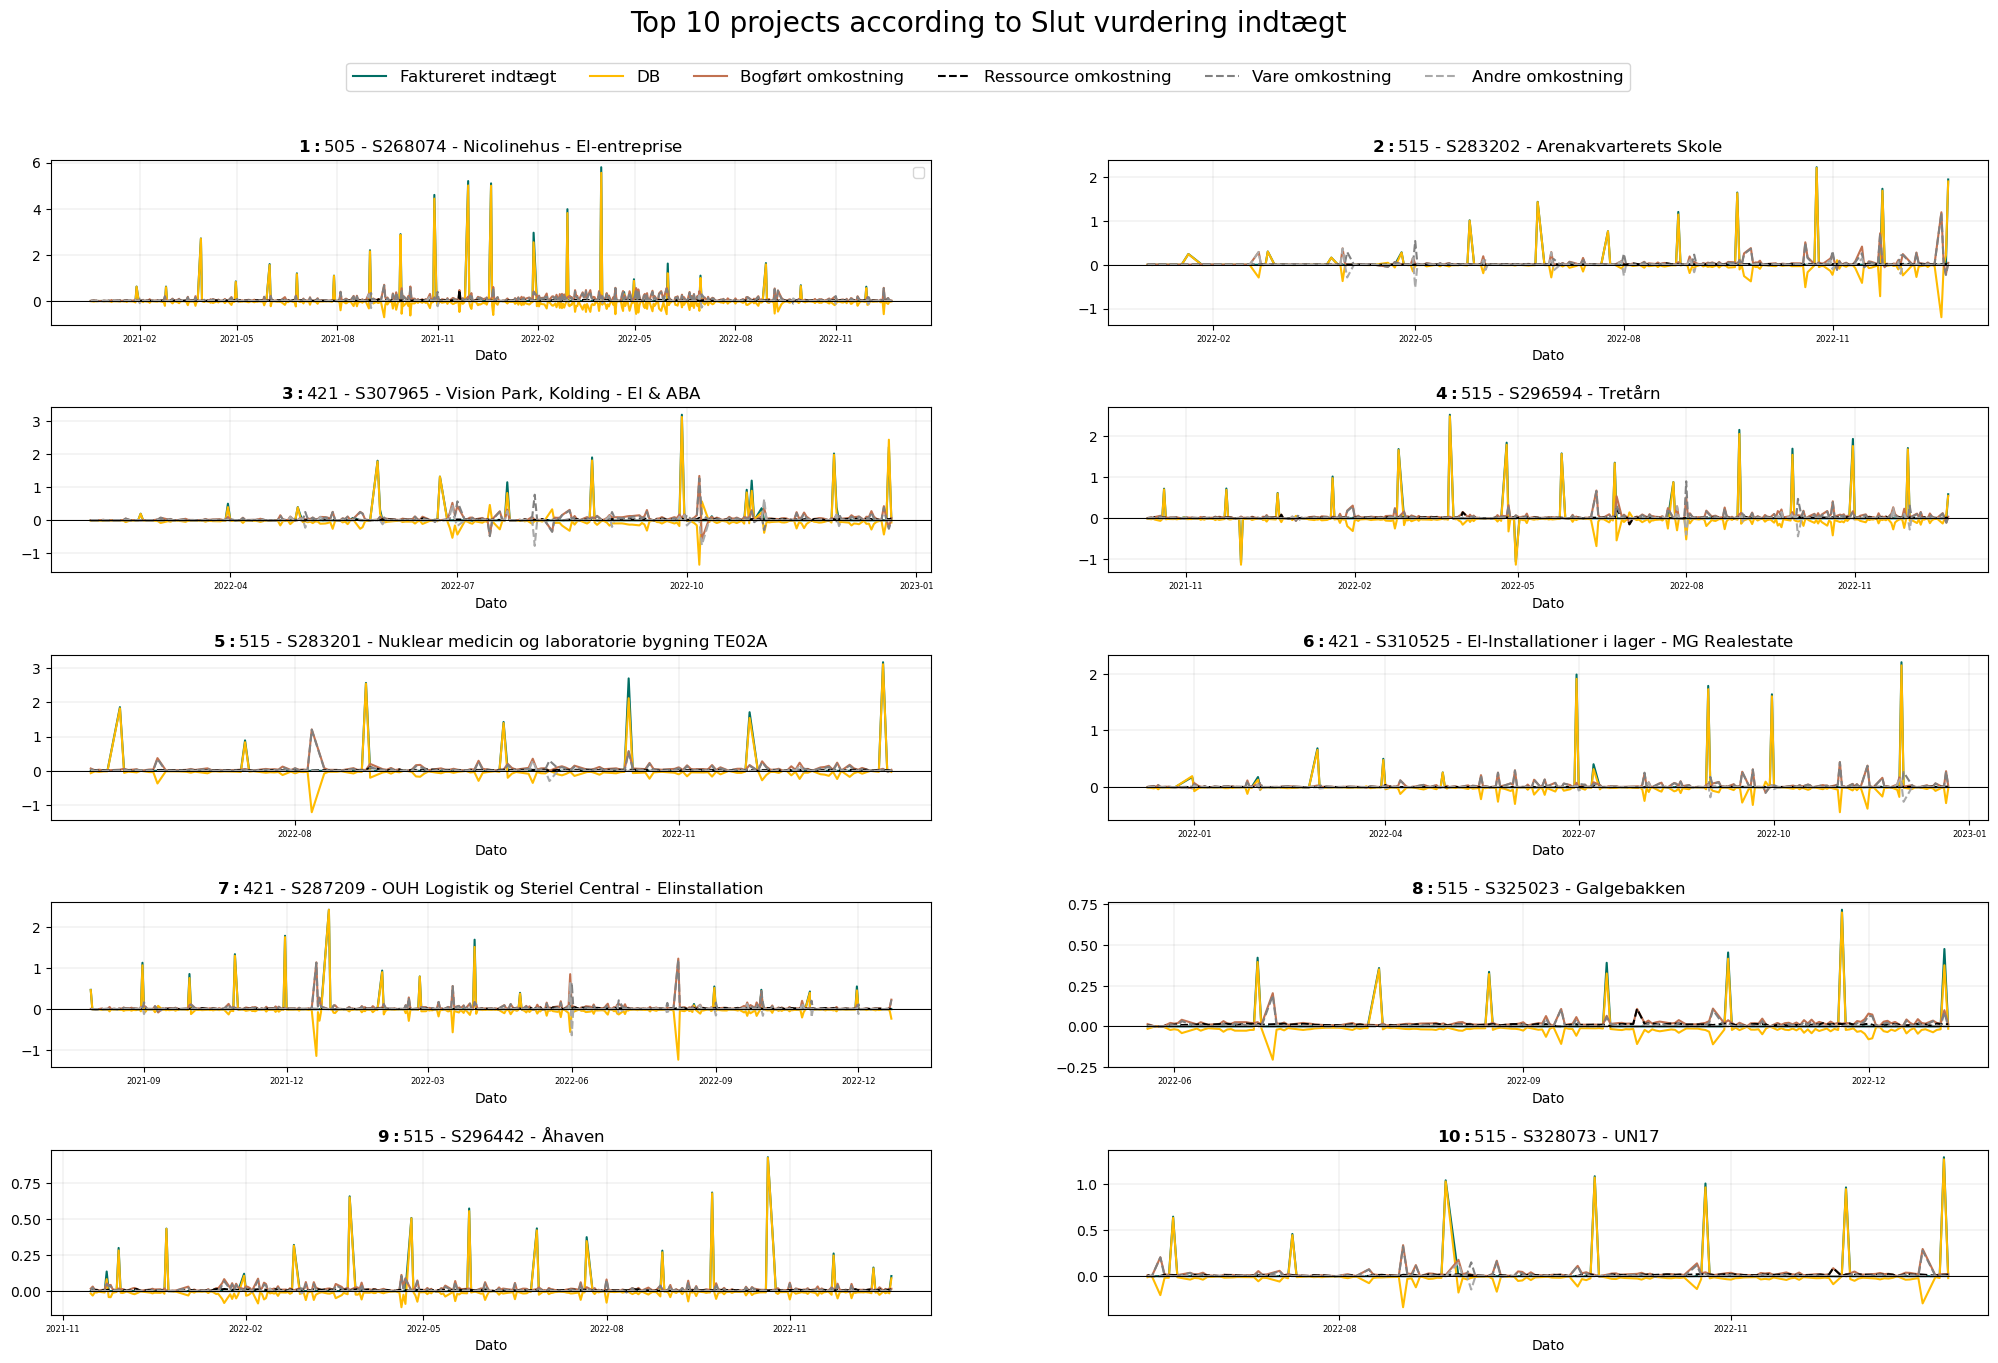

In [12]:
# Plot 10 project in one figure.
fig, ax = plt.subplots(5,2)
# make a little extra space between the subplots
fig.subplots_adjust(hspace=0.5)
# size of the figure
fig.set_size_inches(25, 15)
# Title of the figure
fig.suptitle('Top 10 projects according to ' + param, fontsize=20)


# Project 1
ax[0,0].plot(dfJob1.index, dfJob1['Faktureret indtægt'], color='#006e64')
ax[0,0].plot(dfJob1.index, dfJob1['DB'], color='#ffbb00')
ax[0,0].plot(dfJob1.index, dfJob1['Bogført omkostning'],color='#c17150')
ax[0,0].plot(dfJob1.index, dfJob1['Ressource omkostning'],linestyle='--', color='black')
ax[0,0].plot(dfJob1.index, dfJob1['Vare omkostning'],linestyle='--', color='grey')
ax[0,0].plot(dfJob1.index, dfJob1['Andre omkostning'],linestyle='--', color='darkgrey')
# ax0 = ax[0,0].twinx()
# ax0.plot(dfJob1.index, dfJob1['DG'], color='#ff0000', linestyle = '-.')
# ax0.plot(dfJob1.index, dfJob1['Slut vurdering DG'], linestyle = '-.')
# Legend
ax[0,0].legend()
# Title
ax[0,0].set_title(r"$\bf{1: }$" + dfJob1Desc)
# X-axis
ax[0,0].set_xlabel('Dato')
# Change x-axis ticks to every 3 months
ax[0,0].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
# X-axis label size small
ax[0,0].tick_params(axis='x', labelsize=6)
# Add gridlines grey
ax[0,0].grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
# Add line for y=0
ax[0,0].axhline(y=0, color='black', linestyle='-', linewidth=0.75)

# Project 2
ax[0,1].plot(dfJob2.index, dfJob2['Faktureret indtægt'], color='#006e64')
ax[0,1].plot(dfJob2.index, dfJob2['DB'], color='#ffbb00')
ax[0,1].plot(dfJob2.index, dfJob2['Bogført omkostning'],color='#c17150')
ax[0,1].plot(dfJob2.index, dfJob2['Ressource omkostning'], linestyle='--', color='black')
ax[0,1].plot(dfJob2.index, dfJob2['Vare omkostning'],linestyle='--', color='grey')
ax[0,1].plot(dfJob2.index, dfJob2['Andre omkostning'],linestyle='--', color='darkgrey')
# ax0 = ax[0,1].twinx()
# ax0.plot(dfJob2.index, dfJob2['DG'], color='#ff0000', linestyle = '-.')
# ax0.plot(dfJob2.index, dfJob2['Slut vurdering DG'], linestyle = '-.')
# Title
ax[0,1].set_title(r"$\bf{2: }$" + dfJob2Desc)
# X-axis
ax[0,1].set_xlabel('Dato')
# Change x-axis ticks to every 3 months
ax[0,1].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
# X-axis label size small
ax[0,1].tick_params(axis='x', labelsize=6)
# Add gridlines grey
ax[0,1].grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
# Add line for y=0
ax[0,1].axhline(y=0, color='black', linestyle='-', linewidth=0.75)

# Project 3
ax[1,0].plot(dfJob3.index, dfJob3['Faktureret indtægt'], color='#006e64')
ax[1,0].plot(dfJob3.index, dfJob3['DB'], color='#ffbb00')
ax[1,0].plot(dfJob3.index, dfJob3['Bogført omkostning'],color='#c17150')
ax[1,0].plot(dfJob3.index, dfJob3['Ressource omkostning'],linestyle='--', color='black')
ax[1,0].plot(dfJob3.index, dfJob3['Vare omkostning'],linestyle='--', color='grey')
ax[1,0].plot(dfJob3.index, dfJob3['Andre omkostning'],linestyle='--', color='darkgrey')
# ax0 = ax[1,0].twinx()
# ax0.plot(dfJob3.index, dfJob3['DG'], color='#ff0000', linestyle = '-.')
# ax0.plot(dfJob3.index, dfJob3['Slut vurdering DG'], linestyle = '-.')
# Title
ax[1,0].set_title(r"$\bf{3: }$" + dfJob3Desc)
# X-axis
ax[1,0].set_xlabel('Dato')
# Change x-axis ticks to every 3 months
ax[1,0].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
# X-axis label size small
ax[1,0].tick_params(axis='x', labelsize=6)
# Add gridlines grey
ax[1,0].grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
# Add line for y=0
ax[1,0].axhline(y=0, color='black', linestyle='-', linewidth=0.75)

# Project 4

ax[1,1].plot(dfJob4.index, dfJob4['Faktureret indtægt'], color='#006e64')
ax[1,1].plot(dfJob4.index, dfJob4['DB'], color='#ffbb00')
ax[1,1].plot(dfJob4.index, dfJob4['Bogført omkostning'],color='#c17150')
ax[1,1].plot(dfJob4.index, dfJob4['Ressource omkostning'],linestyle='--', color='black')
ax[1,1].plot(dfJob4.index, dfJob4['Vare omkostning'],linestyle='--', color='grey')
ax[1,1].plot(dfJob4.index, dfJob4['Andre omkostning'],linestyle='--', color='darkgrey')
# ax0 = ax[1,1].twinx()
# ax0.plot(dfJob4.index, dfJob4['DG'], color='#ff0000', linestyle = '-.')
# ax0.plot(dfJob4.index, dfJob4['Slut vurdering DG'], linestyle = '-.')
# Title
ax[1,1].set_title(r"$\bf{4: }$" + dfJob4Desc)
# X-axis
ax[1,1].set_xlabel('Dato')
# Change x-axis ticks to every 3 months
ax[1,1].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
# X-axis label size small
ax[1,1].tick_params(axis='x', labelsize=6)
# Add gridlines grey
ax[1,1].grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
# Add line for y=0
ax[1,1].axhline(y=0, color='black', linestyle='-', linewidth=0.75)

# Project 5
ax[2,0].plot(dfJob5.index, dfJob5['Faktureret indtægt'], color='#006e64')
ax[2,0].plot(dfJob5.index, dfJob5['DB'], color='#ffbb00')
ax[2,0].plot(dfJob5.index, dfJob5['Bogført omkostning'],color='#c17150')
ax[2,0].plot(dfJob5.index, dfJob5['Ressource omkostning'],linestyle='--', color='black')
ax[2,0].plot(dfJob5.index, dfJob5['Vare omkostning'],linestyle='--', color='grey')
ax[2,0].plot(dfJob5.index, dfJob5['Andre omkostning'],linestyle='--', color='darkgrey')
# ax0 = ax[2,0].twinx()
# ax0.plot(dfJob4.index, dfJob4['DG'], color='#ff0000', linestyle = '-.')
# ax0.plot(dfJob4.index, dfJob4['Slut vurdering DG'], linestyle = '-.')
# Title
ax[2,0].set_title(r"$\bf{5: }$" + dfJob5Desc)
# X-axis
ax[2,0].set_xlabel('Dato')
# Change x-axis ticks to every 3 months
ax[2,0].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
# X-axis label size small
ax[2,0].tick_params(axis='x', labelsize=6)
# Add gridlines grey
ax[2,0].grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
# Add line for y=0
ax[2,0].axhline(y=0, color='black', linestyle='-', linewidth=0.75)

# Project 6
ax[2,1].plot(dfJob6.index, dfJob6['Faktureret indtægt'], color='#006e64')
ax[2,1].plot(dfJob6.index, dfJob6['DB'], color='#ffbb00')
ax[2,1].plot(dfJob6.index, dfJob6['Bogført omkostning'],color='#c17150')
ax[2,1].plot(dfJob6.index, dfJob6['Ressource omkostning'],linestyle='--', color='black')
ax[2,1].plot(dfJob6.index, dfJob6['Vare omkostning'],linestyle='--', color='grey')
ax[2,1].plot(dfJob6.index, dfJob6['Andre omkostning'],linestyle='--', color='darkgrey')
# ax0 = ax[2,1].twinx()
# ax0.plot(dfJob6.index, dfJob6['DG'], color='#ff0000', linestyle = '-.')
# ax0.plot(dfJob6.index, dfJob6['Slut vurdering DG'], linestyle = '-.')
# Title
ax[2,1].set_title(r"$\bf{6: }$" + dfJob6Desc)
# X-axis
ax[2,1].set_xlabel('Dato')
# Change x-axis ticks to every 3 months
ax[2,1].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
# X-axis label size small
ax[2,1].tick_params(axis='x', labelsize=6)
# Add gridlines grey
ax[2,1].grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
# Add line for y=0
ax[2,1].axhline(y=0, color='black', linestyle='-', linewidth=0.75)

# Project 7
ax[3,0].plot(dfJob7.index, dfJob7['Faktureret indtægt'], color='#006e64')
ax[3,0].plot(dfJob7.index, dfJob7['DB'], color='#ffbb00')
ax[3,0].plot(dfJob7.index, dfJob7['Bogført omkostning'],color='#c17150')
ax[3,0].plot(dfJob7.index, dfJob7['Ressource omkostning'],linestyle='--', color='black')
ax[3,0].plot(dfJob7.index, dfJob7['Vare omkostning'],linestyle='--', color='grey')
ax[3,0].plot(dfJob7.index, dfJob7['Andre omkostning'],linestyle='--', color='darkgrey')
# ax0 = ax[3,0].twinx()
# ax0.plot(dfJob7.index, dfJob7['DG'], color='#ff0000', linestyle = '-.')
# ax0.plot(dfJob7.index, dfJob7['Slut vurdering DG'], linestyle = '-.')
# Title
ax[3,0].set_title(r"$\bf{7: }$" + dfJob7Desc)
# X-axis
ax[3,0].set_xlabel('Dato')
# Change x-axis ticks to every 3 months
ax[3,0].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
# X-axis label size small
ax[3,0].tick_params(axis='x', labelsize=6)
# Add gridlines grey
ax[3,0].grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
# Add line for y=0
ax[3,0].axhline(y=0, color='black', linestyle='-', linewidth=0.75)

# Project 8
ax[3,1].plot(dfJob8.index, dfJob8['Faktureret indtægt'], color='#006e64')
ax[3,1].plot(dfJob8.index, dfJob8['DB'], color='#ffbb00')
ax[3,1].plot(dfJob8.index, dfJob8['Bogført omkostning'],color='#c17150')
ax[3,1].plot(dfJob8.index, dfJob8['Ressource omkostning'],linestyle='--', color='black')  
ax[3,1].plot(dfJob8.index, dfJob8['Vare omkostning'],linestyle='--', color='grey')
ax[3,1].plot(dfJob8.index, dfJob8['Andre omkostning'],linestyle='--', color='darkgrey')
# ax0 = ax[3,1].twinx()
# ax0.plot(dfJob8.index, dfJob8['DG'], color='#ff0000', linestyle = '-.')
# ax0.plot(dfJob8.index, dfJob8['Slut vurdering DG'], linestyle = '-.')
# Title
ax[3,1].set_title(r"$\bf{8: }$" + dfJob8Desc)
# X-axis
ax[3,1].set_xlabel('Dato')
# Change x-axis ticks to every 3 months
ax[3,1].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
# X-axis label size small
ax[3,1].tick_params(axis='x', labelsize=6)
# Add gridlines grey
ax[3,1].grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
# Add line for y=0
ax[3,1].axhline(y=0, color='black', linestyle='-', linewidth=0.75)

# Project 9
ax[4,0].plot(dfJob9.index, dfJob9['Faktureret indtægt'], color='#006e64')
ax[4,0].plot(dfJob9.index, dfJob9['DB'], color='#ffbb00')
ax[4,0].plot(dfJob9.index, dfJob9['Bogført omkostning'],color='#c17150')
ax[4,0].plot(dfJob9.index, dfJob9['Ressource omkostning'],linestyle='--', color='black')
ax[4,0].plot(dfJob9.index, dfJob9['Vare omkostning'],linestyle='--', color='grey')
ax[4,0].plot(dfJob9.index, dfJob9['Andre omkostning'],linestyle='--', color='darkgrey')
# ax0 = ax[4,0].twinx()
# ax0.plot(dfJob9.index, dfJob9['DG'], color='#ff0000', linestyle = '-.')
# ax0.plot(dfJob9.index, dfJob9['Slut vurdering DG'], linestyle = '-.')
# Title
ax[4,0].set_title(r"$\bf{9: }$" + dfJob9Desc)
# X-axis
ax[4,0].set_xlabel('Dato')
# Change x-axis ticks to every 3 months
ax[4,0].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
# X-axis label size small
ax[4,0].tick_params(axis='x', labelsize=6)
# Add gridlines grey
ax[4,0].grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
# Add line for y=0
ax[4,0].axhline(y=0, color='black', linestyle='-', linewidth=0.75)

# Project 10
ax[4,1].plot(dfJob10.index, dfJob10['Faktureret indtægt'], color='#006e64')
ax[4,1].plot(dfJob10.index, dfJob10['DB'], color='#ffbb00')
ax[4,1].plot(dfJob10.index, dfJob10['Bogført omkostning'],color='#c17150')
ax[4,1].plot(dfJob10.index, dfJob10['Ressource omkostning'],linestyle='--', color='black')
ax[4,1].plot(dfJob10.index, dfJob10['Vare omkostning'],linestyle='--', color='grey')
ax[4,1].plot(dfJob10.index, dfJob10['Andre omkostning'],linestyle='--', color='darkgrey')
# ax0 = ax[4,1].twinx()
# ax0.plot(dfJob10.index, dfJob10['DG'], color='#ff0000', linestyle = '-.')
# ax0.plot(dfJob10.index, dfJob10['Slut vurdering DG'], linestyle = '-.')
# Title
ax[4,1].set_title(r"$\bf{10: }$" + dfJob10Desc)
# X-axis
ax[4,1].set_xlabel('Dato')
# Change x-axis ticks to every 3 months
ax[4,1].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
# X-axis label size small
ax[4,1].tick_params(axis='x', labelsize=6)
# Add gridlines grey
ax[4,1].grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
# Add line for y=0
ax[4,1].axhline(y=0, color='black', linestyle='-', linewidth=0.75)


# Legend below title
# Add label to legend
fig.legend(['Faktureret indtægt', 'DB', 'Bogført omkostning', 'Ressource omkostning', 'Vare omkostning', 'Andre omkostning'],loc='upper center', bbox_to_anchor=(0.5, 0.95), ncol=6, fontsize=12)
# Save plot as pdf
plt.savefig("./Top10Normal.pdf", format="pdf", bbox_inches="tight")
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


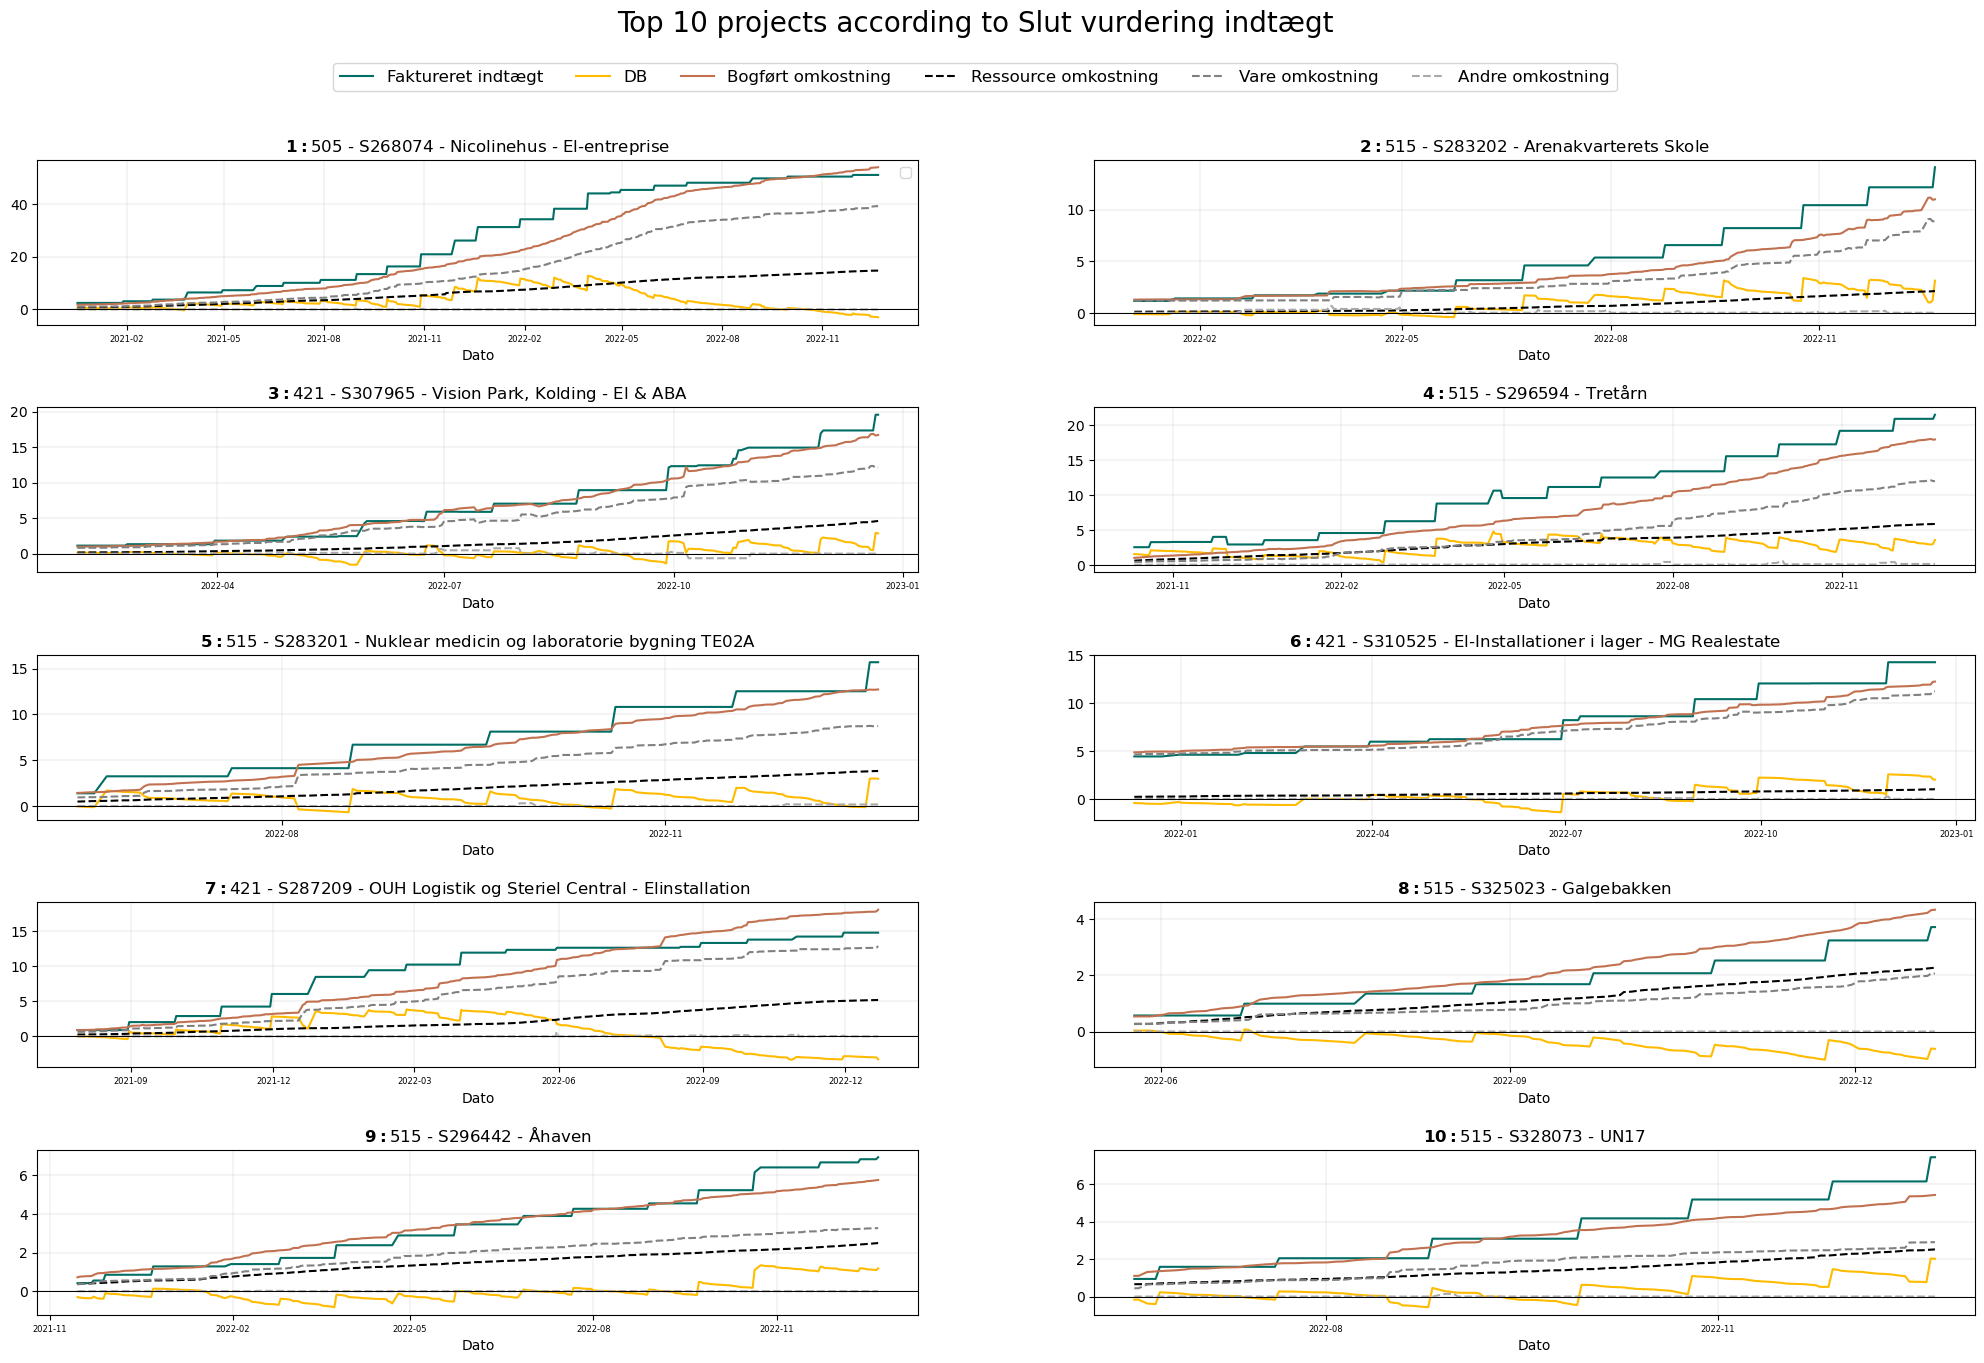

In [13]:
# Plot 10 project in one figure using Sigma.
fig, ax = plt.subplots(5,2)
# make a little extra space between the subplots
fig.subplots_adjust(hspace=0.5)
# size of the figure
fig.set_size_inches(25, 15)
# Title of the figure
fig.suptitle('Top 10 projects according to ' + param, fontsize=20)


# Project 1
ax[0,0].plot(dfJob1.index, dfJob1['Faktureret indtægt Sigma'], color='#006e64')
ax[0,0].plot(dfJob1.index, dfJob1['DB Sigma'], color='#ffbb00')
ax[0,0].plot(dfJob1.index, dfJob1['Bogført omkostning Sigma'],color='#c17150')
ax[0,0].plot(dfJob1.index, dfJob1['Ressource omkostning Sigma'],linestyle='--', color='black')
ax[0,0].plot(dfJob1.index, dfJob1['Vare omkostning Sigma'],linestyle='--', color='grey')
ax[0,0].plot(dfJob1.index, dfJob1['Andre omkostning Sigma'],linestyle='--', color='darkgrey')
# ax0 = ax[0,0].twinx()
# ax0.plot(dfJob1.index, dfJob1['DG'], color='#ff0000', linestyle = '-.')
# ax0.plot(dfJob1.index, dfJob1['Slut vurdering DG'], linestyle = '-.')
# Legend
ax[0,0].legend()
# Title
ax[0,0].set_title(r"$\bf{1: }$" + dfJob1Desc)
# X-axis
ax[0,0].set_xlabel('Dato')
# Change x-axis ticks to every 3 months
ax[0,0].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
# X-axis label size small
ax[0,0].tick_params(axis='x', labelsize=6)
# Add gridlines grey
ax[0,0].grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
# Add line for y=0
ax[0,0].axhline(y=0, color='black', linestyle='-', linewidth=0.75)

# Project 2
ax[0,1].plot(dfJob2.index, dfJob2['Faktureret indtægt Sigma'], color='#006e64')
ax[0,1].plot(dfJob2.index, dfJob2['DB Sigma'], color='#ffbb00')
ax[0,1].plot(dfJob2.index, dfJob2['Bogført omkostning Sigma'],color='#c17150')
ax[0,1].plot(dfJob2.index, dfJob2['Ressource omkostning Sigma'], linestyle='--', color='black')
ax[0,1].plot(dfJob2.index, dfJob2['Vare omkostning Sigma'],linestyle='--', color='grey')
ax[0,1].plot(dfJob2.index, dfJob2['Andre omkostning Sigma'],linestyle='--', color='darkgrey')
# ax0 = ax[0,1].twinx()
# ax0.plot(dfJob2.index, dfJob2['DG'], color='#ff0000', linestyle = '-.')
# ax0.plot(dfJob2.index, dfJob2['Slut vurdering DG'], linestyle = '-.')
# Title
ax[0,1].set_title(r"$\bf{2: }$" + dfJob2Desc)
# X-axis
ax[0,1].set_xlabel('Dato')
# Change x-axis ticks to every 3 months
ax[0,1].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
# X-axis label size small
ax[0,1].tick_params(axis='x', labelsize=6)
# Add gridlines grey
ax[0,1].grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
# Add line for y=0
ax[0,1].axhline(y=0, color='black', linestyle='-', linewidth=0.75)

# Project 3
ax[1,0].plot(dfJob3.index, dfJob3['Faktureret indtægt Sigma'], color='#006e64')
ax[1,0].plot(dfJob3.index, dfJob3['DB Sigma'], color='#ffbb00')
ax[1,0].plot(dfJob3.index, dfJob3['Bogført omkostning Sigma'],color='#c17150')
ax[1,0].plot(dfJob3.index, dfJob3['Ressource omkostning Sigma'],linestyle='--', color='black')
ax[1,0].plot(dfJob3.index, dfJob3['Vare omkostning Sigma'],linestyle='--', color='grey')
ax[1,0].plot(dfJob3.index, dfJob3['Andre omkostning Sigma'],linestyle='--', color='darkgrey')
# ax0 = ax[1,0].twinx()
# ax0.plot(dfJob3.index, dfJob3['DG'], color='#ff0000', linestyle = '-.')
# ax0.plot(dfJob3.index, dfJob3['Slut vurdering DG'], linestyle = '-.')
# Title
ax[1,0].set_title(r"$\bf{3: }$" + dfJob3Desc)
# X-axis
ax[1,0].set_xlabel('Dato')
# Change x-axis ticks to every 3 months
ax[1,0].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
# X-axis label size small
ax[1,0].tick_params(axis='x', labelsize=6)
# Add gridlines grey
ax[1,0].grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
# Add line for y=0
ax[1,0].axhline(y=0, color='black', linestyle='-', linewidth=0.75)

# Project 4

ax[1,1].plot(dfJob4.index, dfJob4['Faktureret indtægt Sigma'], color='#006e64')
ax[1,1].plot(dfJob4.index, dfJob4['DB Sigma'], color='#ffbb00')
ax[1,1].plot(dfJob4.index, dfJob4['Bogført omkostning Sigma'],color='#c17150')
ax[1,1].plot(dfJob4.index, dfJob4['Ressource omkostning Sigma'],linestyle='--', color='black')
ax[1,1].plot(dfJob4.index, dfJob4['Vare omkostning Sigma'],linestyle='--', color='grey')
ax[1,1].plot(dfJob4.index, dfJob4['Andre omkostning Sigma'],linestyle='--', color='darkgrey')
# ax0 = ax[1,1].twinx()
# ax0.plot(dfJob4.index, dfJob4['DG'], color='#ff0000', linestyle = '-.')
# ax0.plot(dfJob4.index, dfJob4['Slut vurdering DG'], linestyle = '-.')
# Title
ax[1,1].set_title(r"$\bf{4: }$" + dfJob4Desc)
# X-axis
ax[1,1].set_xlabel('Dato')
# Change x-axis ticks to every 3 months
ax[1,1].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
# X-axis label size small
ax[1,1].tick_params(axis='x', labelsize=6)
# Add gridlines grey
ax[1,1].grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
# Add line for y=0
ax[1,1].axhline(y=0, color='black', linestyle='-', linewidth=0.75)

# Project 5
ax[2,0].plot(dfJob5.index, dfJob5['Faktureret indtægt Sigma'], color='#006e64')
ax[2,0].plot(dfJob5.index, dfJob5['DB Sigma'], color='#ffbb00')
ax[2,0].plot(dfJob5.index, dfJob5['Bogført omkostning Sigma'],color='#c17150')
ax[2,0].plot(dfJob5.index, dfJob5['Ressource omkostning Sigma'],linestyle='--', color='black')
ax[2,0].plot(dfJob5.index, dfJob5['Vare omkostning Sigma'],linestyle='--', color='grey')
ax[2,0].plot(dfJob5.index, dfJob5['Andre omkostning Sigma'],linestyle='--', color='darkgrey')
# ax0 = ax[2,0].twinx()
# ax0.plot(dfJob4.index, dfJob4['DG'], color='#ff0000', linestyle = '-.')
# ax0.plot(dfJob4.index, dfJob4['Slut vurdering DG'], linestyle = '-.')
# Title
ax[2,0].set_title(r"$\bf{5: }$" + dfJob5Desc)
# X-axis
ax[2,0].set_xlabel('Dato')
# Change x-axis ticks to every 3 months
ax[2,0].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
# X-axis label size small
ax[2,0].tick_params(axis='x', labelsize=6)
# Add gridlines grey
ax[2,0].grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
# Add line for y=0
ax[2,0].axhline(y=0, color='black', linestyle='-', linewidth=0.75)

# Project 6
ax[2,1].plot(dfJob6.index, dfJob6['Faktureret indtægt Sigma'], color='#006e64')
ax[2,1].plot(dfJob6.index, dfJob6['DB Sigma'], color='#ffbb00')
ax[2,1].plot(dfJob6.index, dfJob6['Bogført omkostning Sigma'],color='#c17150')
ax[2,1].plot(dfJob6.index, dfJob6['Ressource omkostning Sigma'],linestyle='--', color='black')
ax[2,1].plot(dfJob6.index, dfJob6['Vare omkostning Sigma'],linestyle='--', color='grey')
ax[2,1].plot(dfJob6.index, dfJob6['Andre omkostning Sigma'],linestyle='--', color='darkgrey')
# ax0 = ax[2,1].twinx()
# ax0.plot(dfJob6.index, dfJob6['DG'], color='#ff0000', linestyle = '-.')
# ax0.plot(dfJob6.index, dfJob6['Slut vurdering DG'], linestyle = '-.')
# Title
ax[2,1].set_title(r"$\bf{6: }$" + dfJob6Desc)
# X-axis
ax[2,1].set_xlabel('Dato')
# Change x-axis ticks to every 3 months
ax[2,1].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
# X-axis label size small
ax[2,1].tick_params(axis='x', labelsize=6)
# Add gridlines grey
ax[2,1].grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
# Add line for y=0
ax[2,1].axhline(y=0, color='black', linestyle='-', linewidth=0.75)

# Project 7
ax[3,0].plot(dfJob7.index, dfJob7['Faktureret indtægt Sigma'], color='#006e64')
ax[3,0].plot(dfJob7.index, dfJob7['DB Sigma'], color='#ffbb00')
ax[3,0].plot(dfJob7.index, dfJob7['Bogført omkostning Sigma'],color='#c17150')
ax[3,0].plot(dfJob7.index, dfJob7['Ressource omkostning Sigma'],linestyle='--', color='black')
ax[3,0].plot(dfJob7.index, dfJob7['Vare omkostning Sigma'],linestyle='--', color='grey')
ax[3,0].plot(dfJob7.index, dfJob7['Andre omkostning Sigma'],linestyle='--', color='darkgrey')
# ax0 = ax[3,0].twinx()
# ax0.plot(dfJob7.index, dfJob7['DG'], color='#ff0000', linestyle = '-.')
# ax0.plot(dfJob7.index, dfJob7['Slut vurdering DG'], linestyle = '-.')
# Title
ax[3,0].set_title(r"$\bf{7: }$" + dfJob7Desc)
# X-axis
ax[3,0].set_xlabel('Dato')
# Change x-axis ticks to every 3 months
ax[3,0].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
# X-axis label size small
ax[3,0].tick_params(axis='x', labelsize=6)
# Add gridlines grey
ax[3,0].grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
# Add line for y=0
ax[3,0].axhline(y=0, color='black', linestyle='-', linewidth=0.75)

# Project 8
ax[3,1].plot(dfJob8.index, dfJob8['Faktureret indtægt Sigma'], color='#006e64')
ax[3,1].plot(dfJob8.index, dfJob8['DB Sigma'], color='#ffbb00')
ax[3,1].plot(dfJob8.index, dfJob8['Bogført omkostning Sigma'],color='#c17150')
ax[3,1].plot(dfJob8.index, dfJob8['Ressource omkostning Sigma'],linestyle='--', color='black')  
ax[3,1].plot(dfJob8.index, dfJob8['Vare omkostning Sigma'],linestyle='--', color='grey')
ax[3,1].plot(dfJob8.index, dfJob8['Andre omkostning Sigma'],linestyle='--', color='darkgrey')
# ax0 = ax[3,1].twinx()
# ax0.plot(dfJob8.index, dfJob8['DG'], color='#ff0000', linestyle = '-.')
# ax0.plot(dfJob8.index, dfJob8['Slut vurdering DG'], linestyle = '-.')
# Title
ax[3,1].set_title(r"$\bf{8: }$" + dfJob8Desc)
# X-axis
ax[3,1].set_xlabel('Dato')
# Change x-axis ticks to every 3 months
ax[3,1].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
# X-axis label size small
ax[3,1].tick_params(axis='x', labelsize=6)
# Add gridlines grey
ax[3,1].grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
# Add line for y=0
ax[3,1].axhline(y=0, color='black', linestyle='-', linewidth=0.75)

# Project 9
ax[4,0].plot(dfJob9.index, dfJob9['Faktureret indtægt Sigma'], color='#006e64')
ax[4,0].plot(dfJob9.index, dfJob9['DB Sigma'], color='#ffbb00')
ax[4,0].plot(dfJob9.index, dfJob9['Bogført omkostning Sigma'],color='#c17150')
ax[4,0].plot(dfJob9.index, dfJob9['Ressource omkostning Sigma'],linestyle='--', color='black')
ax[4,0].plot(dfJob9.index, dfJob9['Vare omkostning Sigma'],linestyle='--', color='grey')
ax[4,0].plot(dfJob9.index, dfJob9['Andre omkostning Sigma'],linestyle='--', color='darkgrey')
# ax0 = ax[4,0].twinx()
# ax0.plot(dfJob9.index, dfJob9['DG'], color='#ff0000', linestyle = '-.')
# ax0.plot(dfJob9.index, dfJob9['Slut vurdering DG'], linestyle = '-.')
# Title
ax[4,0].set_title(r"$\bf{9: }$" + dfJob9Desc)
# X-axis
ax[4,0].set_xlabel('Dato')
# Change x-axis ticks to every 3 months
ax[4,0].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
# X-axis label size small
ax[4,0].tick_params(axis='x', labelsize=6)
# Add gridlines grey
ax[4,0].grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
# Add line for y=0
ax[4,0].axhline(y=0, color='black', linestyle='-', linewidth=0.75)

# Project 10
ax[4,1].plot(dfJob10.index, dfJob10['Faktureret indtægt Sigma'], color='#006e64')
ax[4,1].plot(dfJob10.index, dfJob10['DB Sigma'], color='#ffbb00')
ax[4,1].plot(dfJob10.index, dfJob10['Bogført omkostning Sigma'],color='#c17150')
ax[4,1].plot(dfJob10.index, dfJob10['Ressource omkostning Sigma'],linestyle='--', color='black')
ax[4,1].plot(dfJob10.index, dfJob10['Vare omkostning Sigma'],linestyle='--', color='grey')
ax[4,1].plot(dfJob10.index, dfJob10['Andre omkostning Sigma'],linestyle='--', color='darkgrey')
# ax0 = ax[4,1].twinx()
# ax0.plot(dfJob10.index, dfJob10['DG'], color='#ff0000', linestyle = '-.')
# ax0.plot(dfJob10.index, dfJob10['Slut vurdering DG'], linestyle = '-.')
# Title
ax[4,1].set_title(r"$\bf{10: }$" + dfJob10Desc)
# X-axis
ax[4,1].set_xlabel('Dato')
# Change x-axis ticks to every 3 months
ax[4,1].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
# X-axis label size small
ax[4,1].tick_params(axis='x', labelsize=6)
# Add gridlines grey
ax[4,1].grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
# Add line for y=0
ax[4,1].axhline(y=0, color='black', linestyle='-', linewidth=0.75)


# Legend below title
# Add label to legend
fig.legend(['Faktureret indtægt', 'DB', 'Bogført omkostning', 'Ressource omkostning', 'Vare omkostning', 'Andre omkostning'],loc='upper center', bbox_to_anchor=(0.5, 0.95), ncol=6, fontsize=12)
# Save plot as pdf
plt.savefig("./Top10Sigma.pdf", format="pdf", bbox_inches="tight")
plt.show()

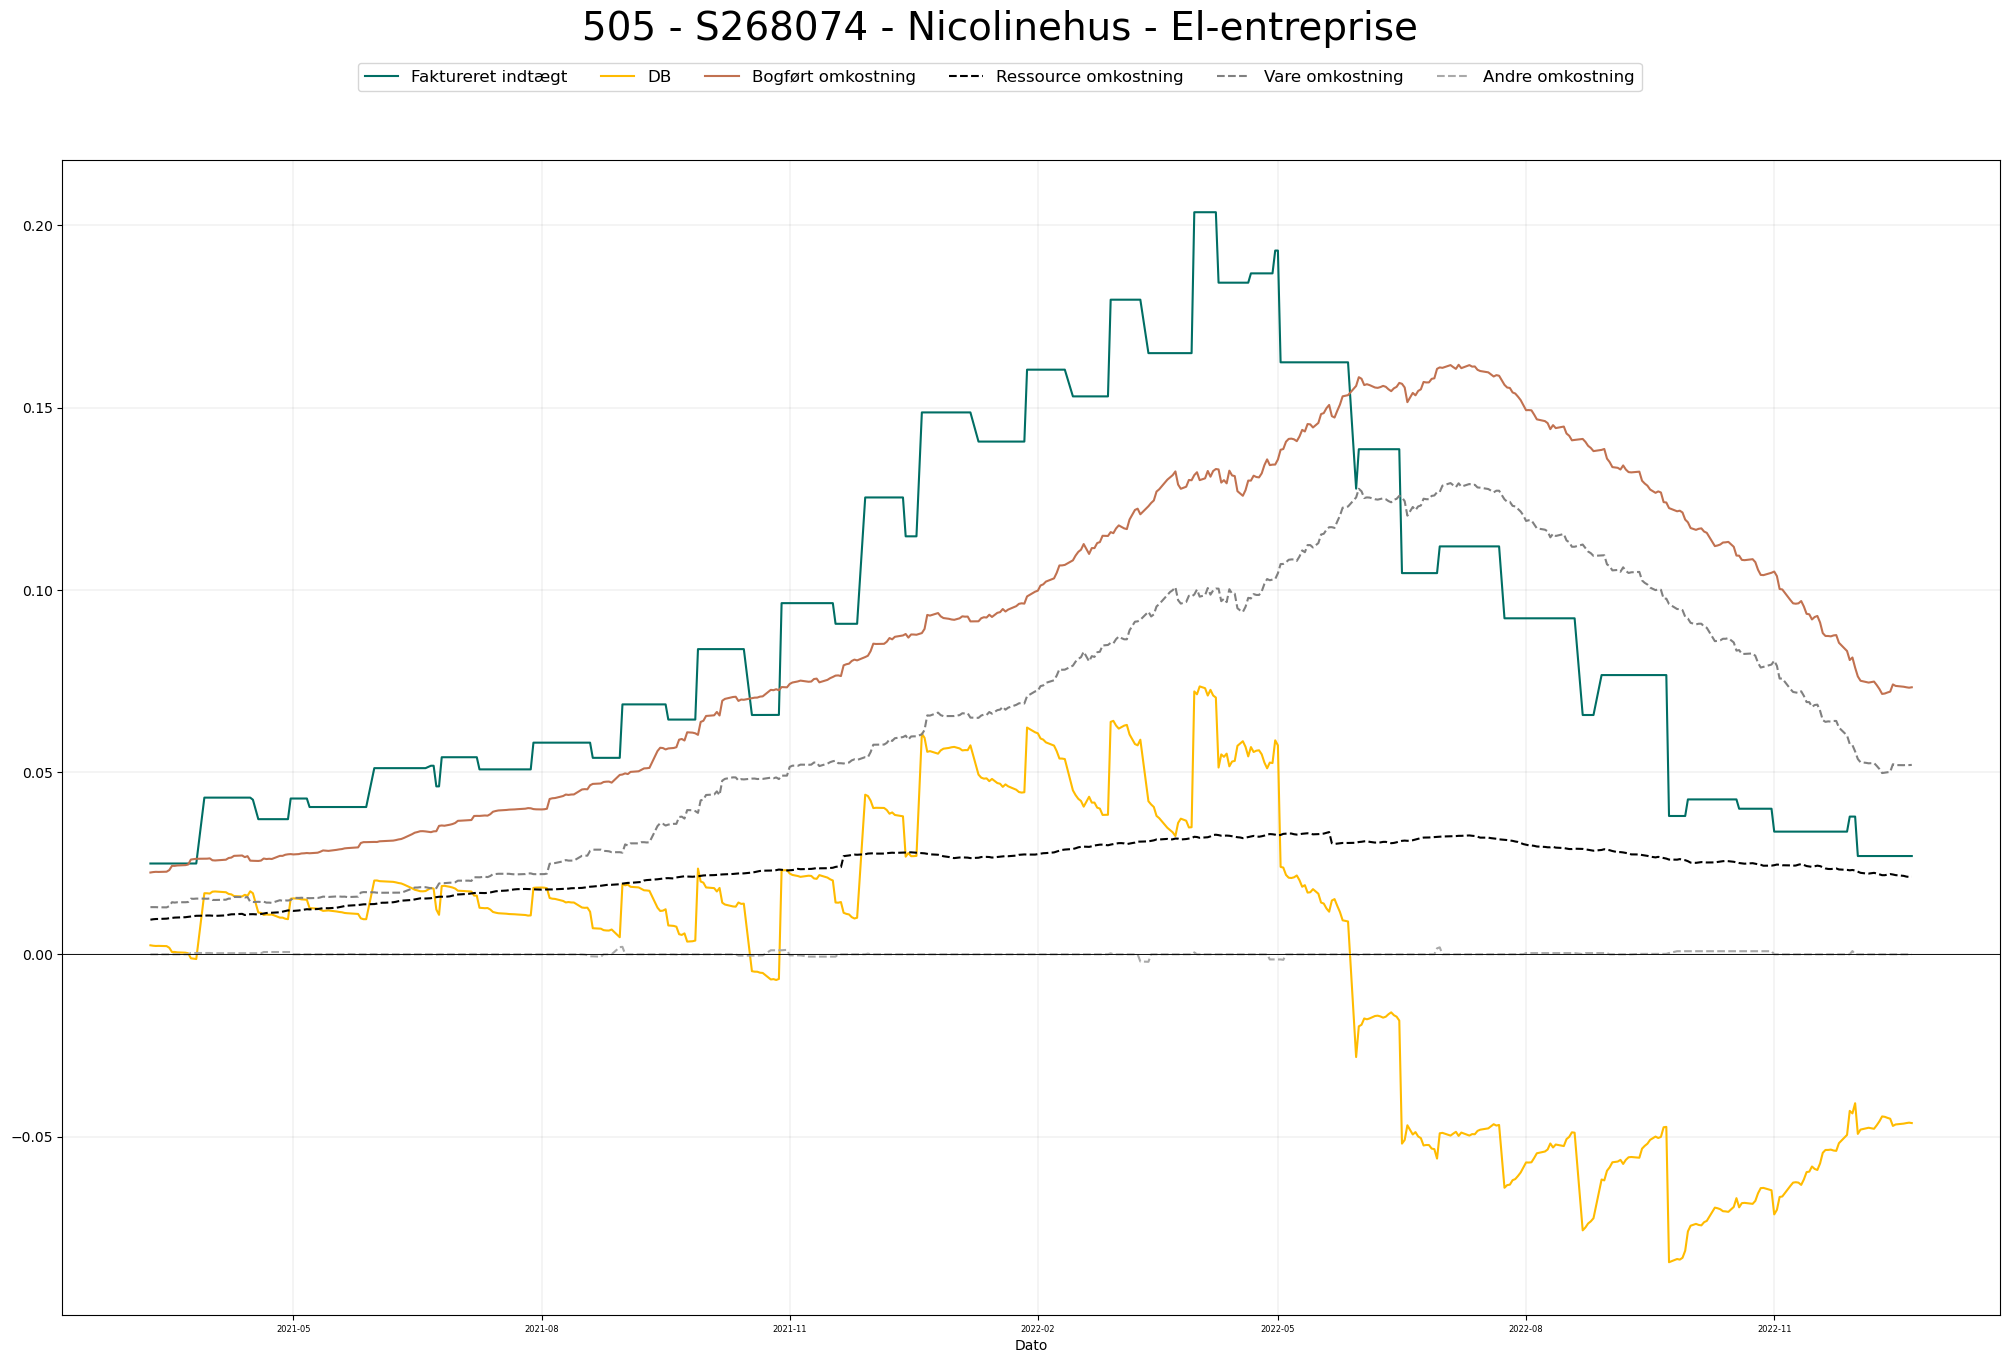

In [39]:
# Plot 10 project in one figure using mu.
fig, ax = plt.subplots(1,1)

# size of the figure
fig.set_size_inches(25, 15)
# Title of the figure
fig.suptitle(dfJob1Desc, fontsize=28)


# Project 1
ax.plot(dfJob1.index, dfJob1['Faktureret indtægt mu'], color='#006e64')
ax.plot(dfJob1.index, dfJob1['DB mu'], color='#ffbb00')
ax.plot(dfJob1.index, dfJob1['Bogført omkostning mu'],color='#c17150')
ax.plot(dfJob1.index, dfJob1['Ressource omkostning mu'],linestyle='--', color='black')
ax.plot(dfJob1.index, dfJob1['Vare omkostning mu'],linestyle='--', color='grey')
ax.plot(dfJob1.index, dfJob1['Andre omkostning mu'],linestyle='--', color='darkgrey')
# ax0 = ax[0,0].twinx()
# ax0.plot(dfJob1.index, dfJob1['DG'], color='#ff0000', linestyle = '-.')
# ax0.plot(dfJob1.index, dfJob1['Slut vurdering DG'], linestyle = '-.')

# X-axis
ax.set_xlabel('Dato')
# Change x-axis ticks to every 3 months
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
# X-axis label size small
ax.tick_params(axis='x', labelsize=6)
# Add gridlines grey
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
# Add line for y=0
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.65)

fig.legend(['Faktureret indtægt', 'DB', 'Bogført omkostning', 'Ressource omkostning', 'Vare omkostning', 'Andre omkostning'],loc='upper center', bbox_to_anchor=(0.5, 0.95), ncol=6, fontsize=12)
# Save plot as pdf
plt.savefig("./Top1.pdf", format="pdf", bbox_inches="tight")
plt.show()


In [ ]:
## Create a plot of DB over time


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


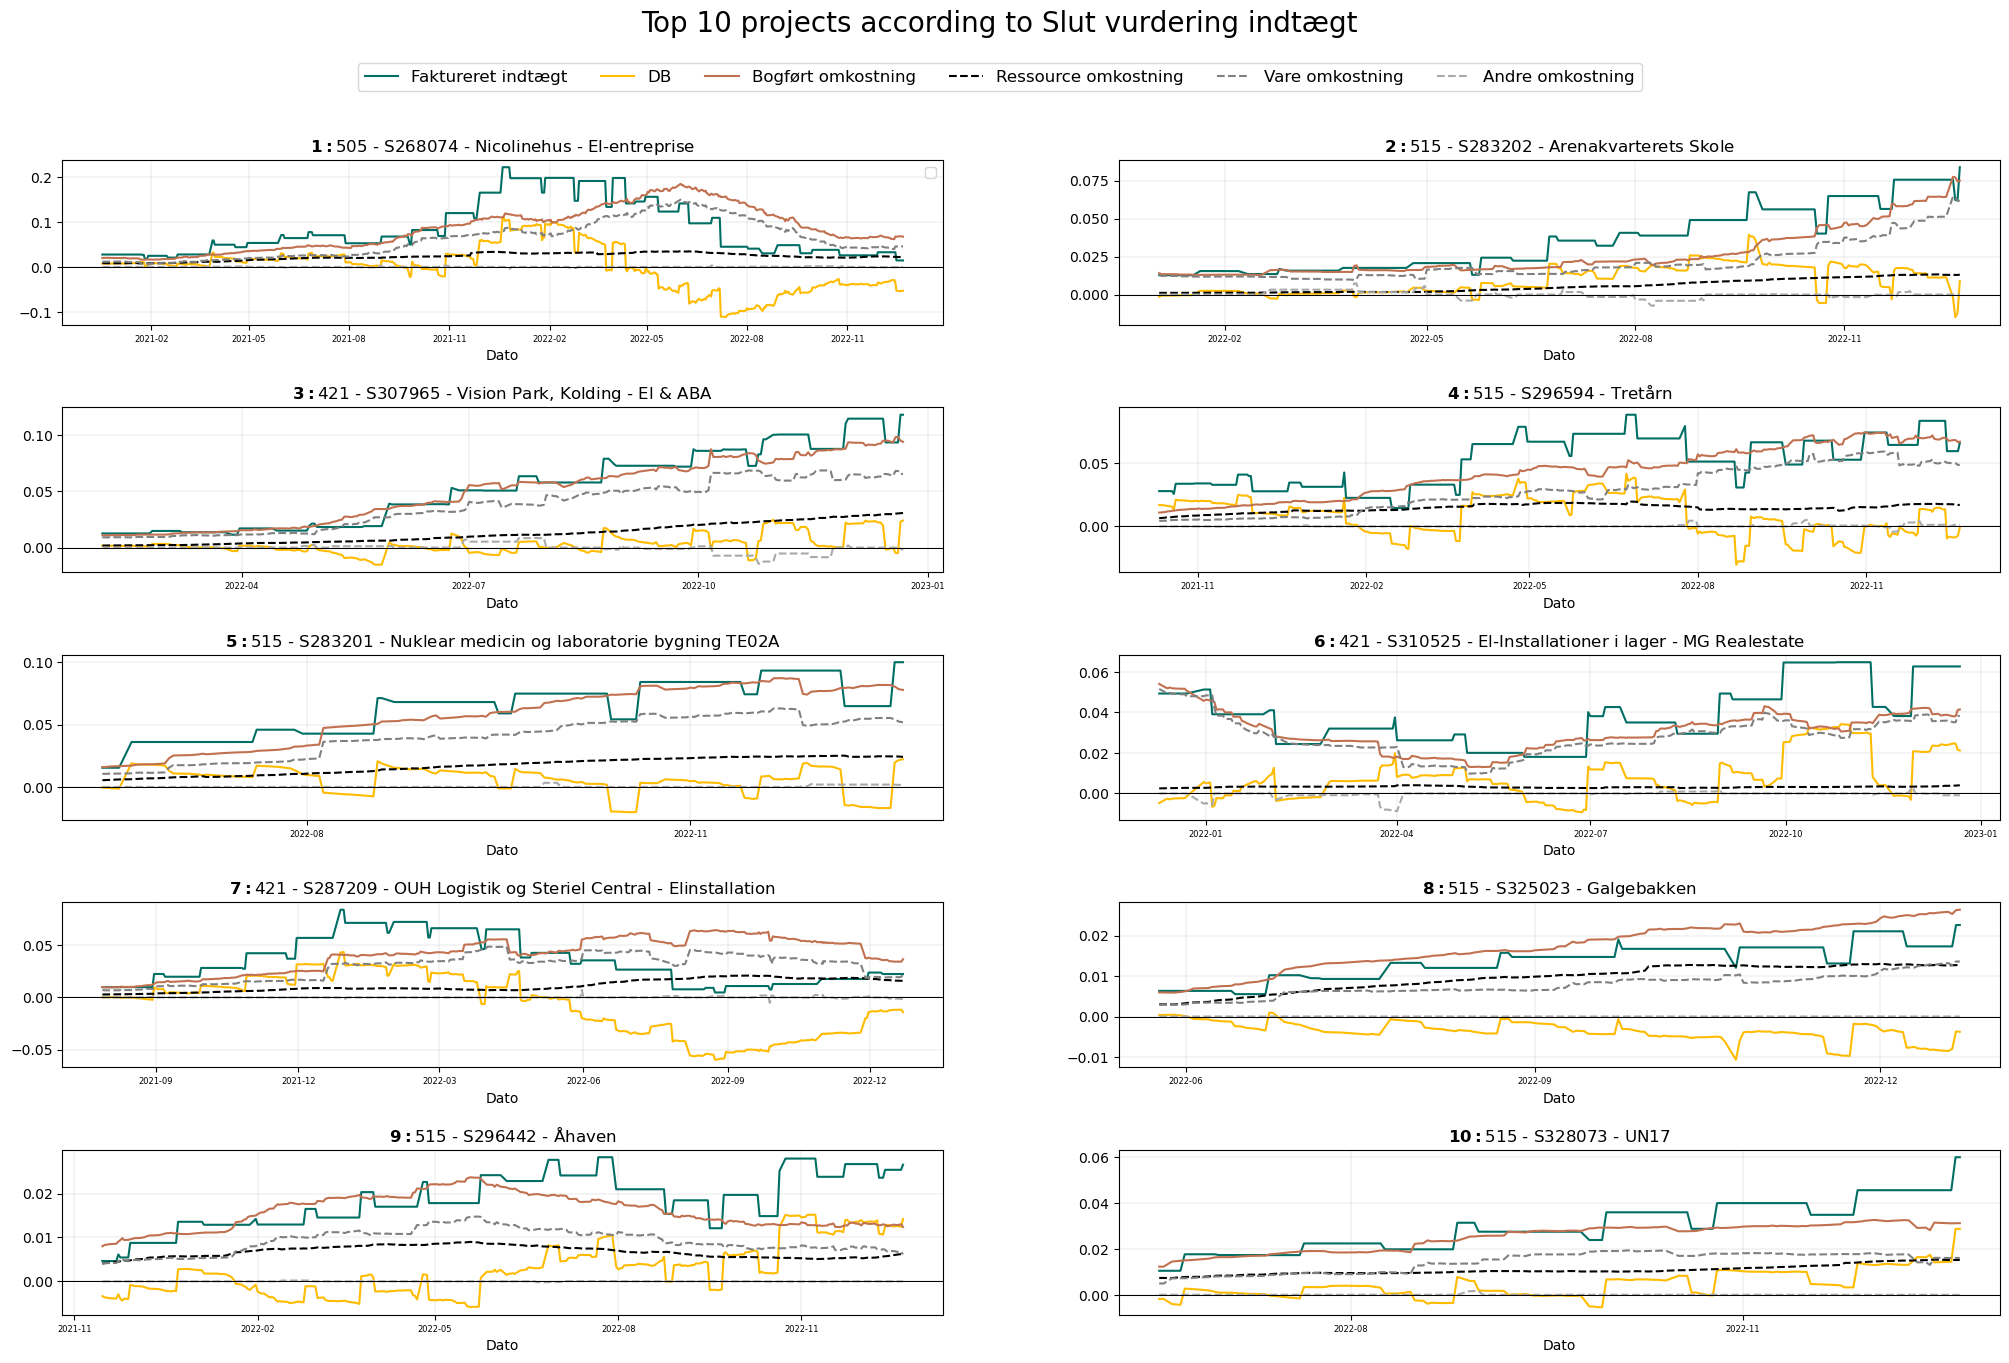

In [14]:
# Plot 10 project in one figure using mu.
fig, ax = plt.subplots(5,2)
# make a little extra space between the subplots
fig.subplots_adjust(hspace=0.5)
# size of the figure
fig.set_size_inches(25, 15)
# Title of the figure
fig.suptitle('Top 10 projects according to ' + param, fontsize=20)


# Project 1
ax[0,0].plot(dfJob1.index, dfJob1['Faktureret indtægt mu'], color='#006e64')
ax[0,0].plot(dfJob1.index, dfJob1['DB mu'], color='#ffbb00')
ax[0,0].plot(dfJob1.index, dfJob1['Bogført omkostning mu'],color='#c17150')
ax[0,0].plot(dfJob1.index, dfJob1['Ressource omkostning mu'],linestyle='--', color='black')
ax[0,0].plot(dfJob1.index, dfJob1['Vare omkostning mu'],linestyle='--', color='grey')
ax[0,0].plot(dfJob1.index, dfJob1['Andre omkostning mu'],linestyle='--', color='darkgrey')
# ax0 = ax[0,0].twinx()
# ax0.plot(dfJob1.index, dfJob1['DG'], color='#ff0000', linestyle = '-.')
# ax0.plot(dfJob1.index, dfJob1['Slut vurdering DG'], linestyle = '-.')
# Legend
ax[0,0].legend()
# Title
ax[0,0].set_title(r"$\bf{1: }$" + dfJob1Desc)
# X-axis
ax[0,0].set_xlabel('Dato')
# Change x-axis ticks to every 3 months
ax[0,0].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
# X-axis label size small
ax[0,0].tick_params(axis='x', labelsize=6)
# Add gridlines grey
ax[0,0].grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
# Add line for y=0
ax[0,0].axhline(y=0, color='black', linestyle='-', linewidth=0.75)

# Project 2
ax[0,1].plot(dfJob2.index, dfJob2['Faktureret indtægt mu'], color='#006e64')
ax[0,1].plot(dfJob2.index, dfJob2['DB mu'], color='#ffbb00')
ax[0,1].plot(dfJob2.index, dfJob2['Bogført omkostning mu'],color='#c17150')
ax[0,1].plot(dfJob2.index, dfJob2['Ressource omkostning mu'], linestyle='--', color='black')
ax[0,1].plot(dfJob2.index, dfJob2['Vare omkostning mu'],linestyle='--', color='grey')
ax[0,1].plot(dfJob2.index, dfJob2['Andre omkostning mu'],linestyle='--', color='darkgrey')
# ax0 = ax[0,1].twinx()
# ax0.plot(dfJob2.index, dfJob2['DG'], color='#ff0000', linestyle = '-.')
# ax0.plot(dfJob2.index, dfJob2['Slut vurdering DG'], linestyle = '-.')
# Title
ax[0,1].set_title(r"$\bf{2: }$" + dfJob2Desc)
# X-axis
ax[0,1].set_xlabel('Dato')
# Change x-axis ticks to every 3 months
ax[0,1].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
# X-axis label size small
ax[0,1].tick_params(axis='x', labelsize=6)
# Add gridlines grey
ax[0,1].grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
# Add line for y=0
ax[0,1].axhline(y=0, color='black', linestyle='-', linewidth=0.75)

# Project 3
ax[1,0].plot(dfJob3.index, dfJob3['Faktureret indtægt mu'], color='#006e64')
ax[1,0].plot(dfJob3.index, dfJob3['DB mu'], color='#ffbb00')
ax[1,0].plot(dfJob3.index, dfJob3['Bogført omkostning mu'],color='#c17150')
ax[1,0].plot(dfJob3.index, dfJob3['Ressource omkostning mu'],linestyle='--', color='black')
ax[1,0].plot(dfJob3.index, dfJob3['Vare omkostning mu'],linestyle='--', color='grey')
ax[1,0].plot(dfJob3.index, dfJob3['Andre omkostning mu'],linestyle='--', color='darkgrey')
# ax0 = ax[1,0].twinx()
# ax0.plot(dfJob3.index, dfJob3['DG'], color='#ff0000', linestyle = '-.')
# ax0.plot(dfJob3.index, dfJob3['Slut vurdering DG'], linestyle = '-.')
# Title
ax[1,0].set_title(r"$\bf{3: }$" + dfJob3Desc)
# X-axis
ax[1,0].set_xlabel('Dato')
# Change x-axis ticks to every 3 months
ax[1,0].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
# X-axis label size small
ax[1,0].tick_params(axis='x', labelsize=6)
# Add gridlines grey
ax[1,0].grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
# Add line for y=0
ax[1,0].axhline(y=0, color='black', linestyle='-', linewidth=0.75)

# Project 4

ax[1,1].plot(dfJob4.index, dfJob4['Faktureret indtægt mu'], color='#006e64')
ax[1,1].plot(dfJob4.index, dfJob4['DB mu'], color='#ffbb00')
ax[1,1].plot(dfJob4.index, dfJob4['Bogført omkostning mu'],color='#c17150')
ax[1,1].plot(dfJob4.index, dfJob4['Ressource omkostning mu'],linestyle='--', color='black')
ax[1,1].plot(dfJob4.index, dfJob4['Vare omkostning mu'],linestyle='--', color='grey')
ax[1,1].plot(dfJob4.index, dfJob4['Andre omkostning mu'],linestyle='--', color='darkgrey')
# ax0 = ax[1,1].twinx()
# ax0.plot(dfJob4.index, dfJob4['DG'], color='#ff0000', linestyle = '-.')
# ax0.plot(dfJob4.index, dfJob4['Slut vurdering DG'], linestyle = '-.')
# Title
ax[1,1].set_title(r"$\bf{4: }$" + dfJob4Desc)
# X-axis
ax[1,1].set_xlabel('Dato')
# Change x-axis ticks to every 3 months
ax[1,1].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
# X-axis label size small
ax[1,1].tick_params(axis='x', labelsize=6)
# Add gridlines grey
ax[1,1].grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
# Add line for y=0
ax[1,1].axhline(y=0, color='black', linestyle='-', linewidth=0.75)

# Project 5
ax[2,0].plot(dfJob5.index, dfJob5['Faktureret indtægt mu'], color='#006e64')
ax[2,0].plot(dfJob5.index, dfJob5['DB mu'], color='#ffbb00')
ax[2,0].plot(dfJob5.index, dfJob5['Bogført omkostning mu'],color='#c17150')
ax[2,0].plot(dfJob5.index, dfJob5['Ressource omkostning mu'],linestyle='--', color='black')
ax[2,0].plot(dfJob5.index, dfJob5['Vare omkostning mu'],linestyle='--', color='grey')
ax[2,0].plot(dfJob5.index, dfJob5['Andre omkostning mu'],linestyle='--', color='darkgrey')
# ax0 = ax[2,0].twinx()
# ax0.plot(dfJob4.index, dfJob4['DG'], color='#ff0000', linestyle = '-.')
# ax0.plot(dfJob4.index, dfJob4['Slut vurdering DG'], linestyle = '-.')
# Title
ax[2,0].set_title(r"$\bf{5: }$" + dfJob5Desc)
# X-axis
ax[2,0].set_xlabel('Dato')
# Change x-axis ticks to every 3 months
ax[2,0].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
# X-axis label size small
ax[2,0].tick_params(axis='x', labelsize=6)
# Add gridlines grey
ax[2,0].grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
# Add line for y=0
ax[2,0].axhline(y=0, color='black', linestyle='-', linewidth=0.75)

# Project 6
ax[2,1].plot(dfJob6.index, dfJob6['Faktureret indtægt mu'], color='#006e64')
ax[2,1].plot(dfJob6.index, dfJob6['DB mu'], color='#ffbb00')
ax[2,1].plot(dfJob6.index, dfJob6['Bogført omkostning mu'],color='#c17150')
ax[2,1].plot(dfJob6.index, dfJob6['Ressource omkostning mu'],linestyle='--', color='black')
ax[2,1].plot(dfJob6.index, dfJob6['Vare omkostning mu'],linestyle='--', color='grey')
ax[2,1].plot(dfJob6.index, dfJob6['Andre omkostning mu'],linestyle='--', color='darkgrey')
# ax0 = ax[2,1].twinx()
# ax0.plot(dfJob6.index, dfJob6['DG'], color='#ff0000', linestyle = '-.')
# ax0.plot(dfJob6.index, dfJob6['Slut vurdering DG'], linestyle = '-.')
# Title
ax[2,1].set_title(r"$\bf{6: }$" + dfJob6Desc)
# X-axis
ax[2,1].set_xlabel('Dato')
# Change x-axis ticks to every 3 months
ax[2,1].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
# X-axis label size small
ax[2,1].tick_params(axis='x', labelsize=6)
# Add gridlines grey
ax[2,1].grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
# Add line for y=0
ax[2,1].axhline(y=0, color='black', linestyle='-', linewidth=0.75)

# Project 7
ax[3,0].plot(dfJob7.index, dfJob7['Faktureret indtægt mu'], color='#006e64')
ax[3,0].plot(dfJob7.index, dfJob7['DB mu'], color='#ffbb00')
ax[3,0].plot(dfJob7.index, dfJob7['Bogført omkostning mu'],color='#c17150')
ax[3,0].plot(dfJob7.index, dfJob7['Ressource omkostning mu'],linestyle='--', color='black')
ax[3,0].plot(dfJob7.index, dfJob7['Vare omkostning mu'],linestyle='--', color='grey')
ax[3,0].plot(dfJob7.index, dfJob7['Andre omkostning mu'],linestyle='--', color='darkgrey')
# ax0 = ax[3,0].twinx()
# ax0.plot(dfJob7.index, dfJob7['DG'], color='#ff0000', linestyle = '-.')
# ax0.plot(dfJob7.index, dfJob7['Slut vurdering DG'], linestyle = '-.')
# Title
ax[3,0].set_title(r"$\bf{7: }$" + dfJob7Desc)
# X-axis
ax[3,0].set_xlabel('Dato')
# Change x-axis ticks to every 3 months
ax[3,0].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
# X-axis label size small
ax[3,0].tick_params(axis='x', labelsize=6)
# Add gridlines grey
ax[3,0].grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
# Add line for y=0
ax[3,0].axhline(y=0, color='black', linestyle='-', linewidth=0.75)

# Project 8
ax[3,1].plot(dfJob8.index, dfJob8['Faktureret indtægt mu'], color='#006e64')
ax[3,1].plot(dfJob8.index, dfJob8['DB mu'], color='#ffbb00')
ax[3,1].plot(dfJob8.index, dfJob8['Bogført omkostning mu'],color='#c17150')
ax[3,1].plot(dfJob8.index, dfJob8['Ressource omkostning mu'],linestyle='--', color='black')  
ax[3,1].plot(dfJob8.index, dfJob8['Vare omkostning mu'],linestyle='--', color='grey')
ax[3,1].plot(dfJob8.index, dfJob8['Andre omkostning mu'],linestyle='--', color='darkgrey')
# ax0 = ax[3,1].twinx()
# ax0.plot(dfJob8.index, dfJob8['DG'], color='#ff0000', linestyle = '-.')
# ax0.plot(dfJob8.index, dfJob8['Slut vurdering DG'], linestyle = '-.')
# Title
ax[3,1].set_title(r"$\bf{8: }$" + dfJob8Desc)
# X-axis
ax[3,1].set_xlabel('Dato')
# Change x-axis ticks to every 3 months
ax[3,1].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
# X-axis label size small
ax[3,1].tick_params(axis='x', labelsize=6)
# Add gridlines grey
ax[3,1].grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
# Add line for y=0
ax[3,1].axhline(y=0, color='black', linestyle='-', linewidth=0.75)

# Project 9
ax[4,0].plot(dfJob9.index, dfJob9['Faktureret indtægt mu'], color='#006e64')
ax[4,0].plot(dfJob9.index, dfJob9['DB mu'], color='#ffbb00')
ax[4,0].plot(dfJob9.index, dfJob9['Bogført omkostning mu'],color='#c17150')
ax[4,0].plot(dfJob9.index, dfJob9['Ressource omkostning mu'],linestyle='--', color='black')
ax[4,0].plot(dfJob9.index, dfJob9['Vare omkostning mu'],linestyle='--', color='grey')
ax[4,0].plot(dfJob9.index, dfJob9['Andre omkostning mu'],linestyle='--', color='darkgrey')
# ax0 = ax[4,0].twinx()
# ax0.plot(dfJob9.index, dfJob9['DG'], color='#ff0000', linestyle = '-.')
# ax0.plot(dfJob9.index, dfJob9['Slut vurdering DG'], linestyle = '-.')
# Title
ax[4,0].set_title(r"$\bf{9: }$" + dfJob9Desc)
# X-axis
ax[4,0].set_xlabel('Dato')
# Change x-axis ticks to every 3 months
ax[4,0].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
# X-axis label size small
ax[4,0].tick_params(axis='x', labelsize=6)
# Add gridlines grey
ax[4,0].grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
# Add line for y=0
ax[4,0].axhline(y=0, color='black', linestyle='-', linewidth=0.75)

# Project 10
ax[4,1].plot(dfJob10.index, dfJob10['Faktureret indtægt mu'], color='#006e64')
ax[4,1].plot(dfJob10.index, dfJob10['DB mu'], color='#ffbb00')
ax[4,1].plot(dfJob10.index, dfJob10['Bogført omkostning mu'],color='#c17150')
ax[4,1].plot(dfJob10.index, dfJob10['Ressource omkostning mu'],linestyle='--', color='black')
ax[4,1].plot(dfJob10.index, dfJob10['Vare omkostning mu'],linestyle='--', color='grey')
ax[4,1].plot(dfJob10.index, dfJob10['Andre omkostning mu'],linestyle='--', color='darkgrey')
# ax0 = ax[4,1].twinx()
# ax0.plot(dfJob10.index, dfJob10['DG'], color='#ff0000', linestyle = '-.')
# ax0.plot(dfJob10.index, dfJob10['Slut vurdering DG'], linestyle = '-.')
# Title
ax[4,1].set_title(r"$\bf{10: }$" + dfJob10Desc)
# X-axis
ax[4,1].set_xlabel('Dato')
# Change x-axis ticks to every 3 months
ax[4,1].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
# X-axis label size small
ax[4,1].tick_params(axis='x', labelsize=6)
# Add gridlines grey
ax[4,1].grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
# Add line for y=0
ax[4,1].axhline(y=0, color='black', linestyle='-', linewidth=0.75)


# Legend below title
# Add label to legend
fig.legend(['Faktureret indtægt', 'DB', 'Bogført omkostning', 'Ressource omkostning', 'Vare omkostning', 'Andre omkostning'],loc='upper center', bbox_to_anchor=(0.5, 0.95), ncol=6, fontsize=12)
# Save plot as pdf
plt.savefig("./Top10mu.pdf", format="pdf", bbox_inches="tight")
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


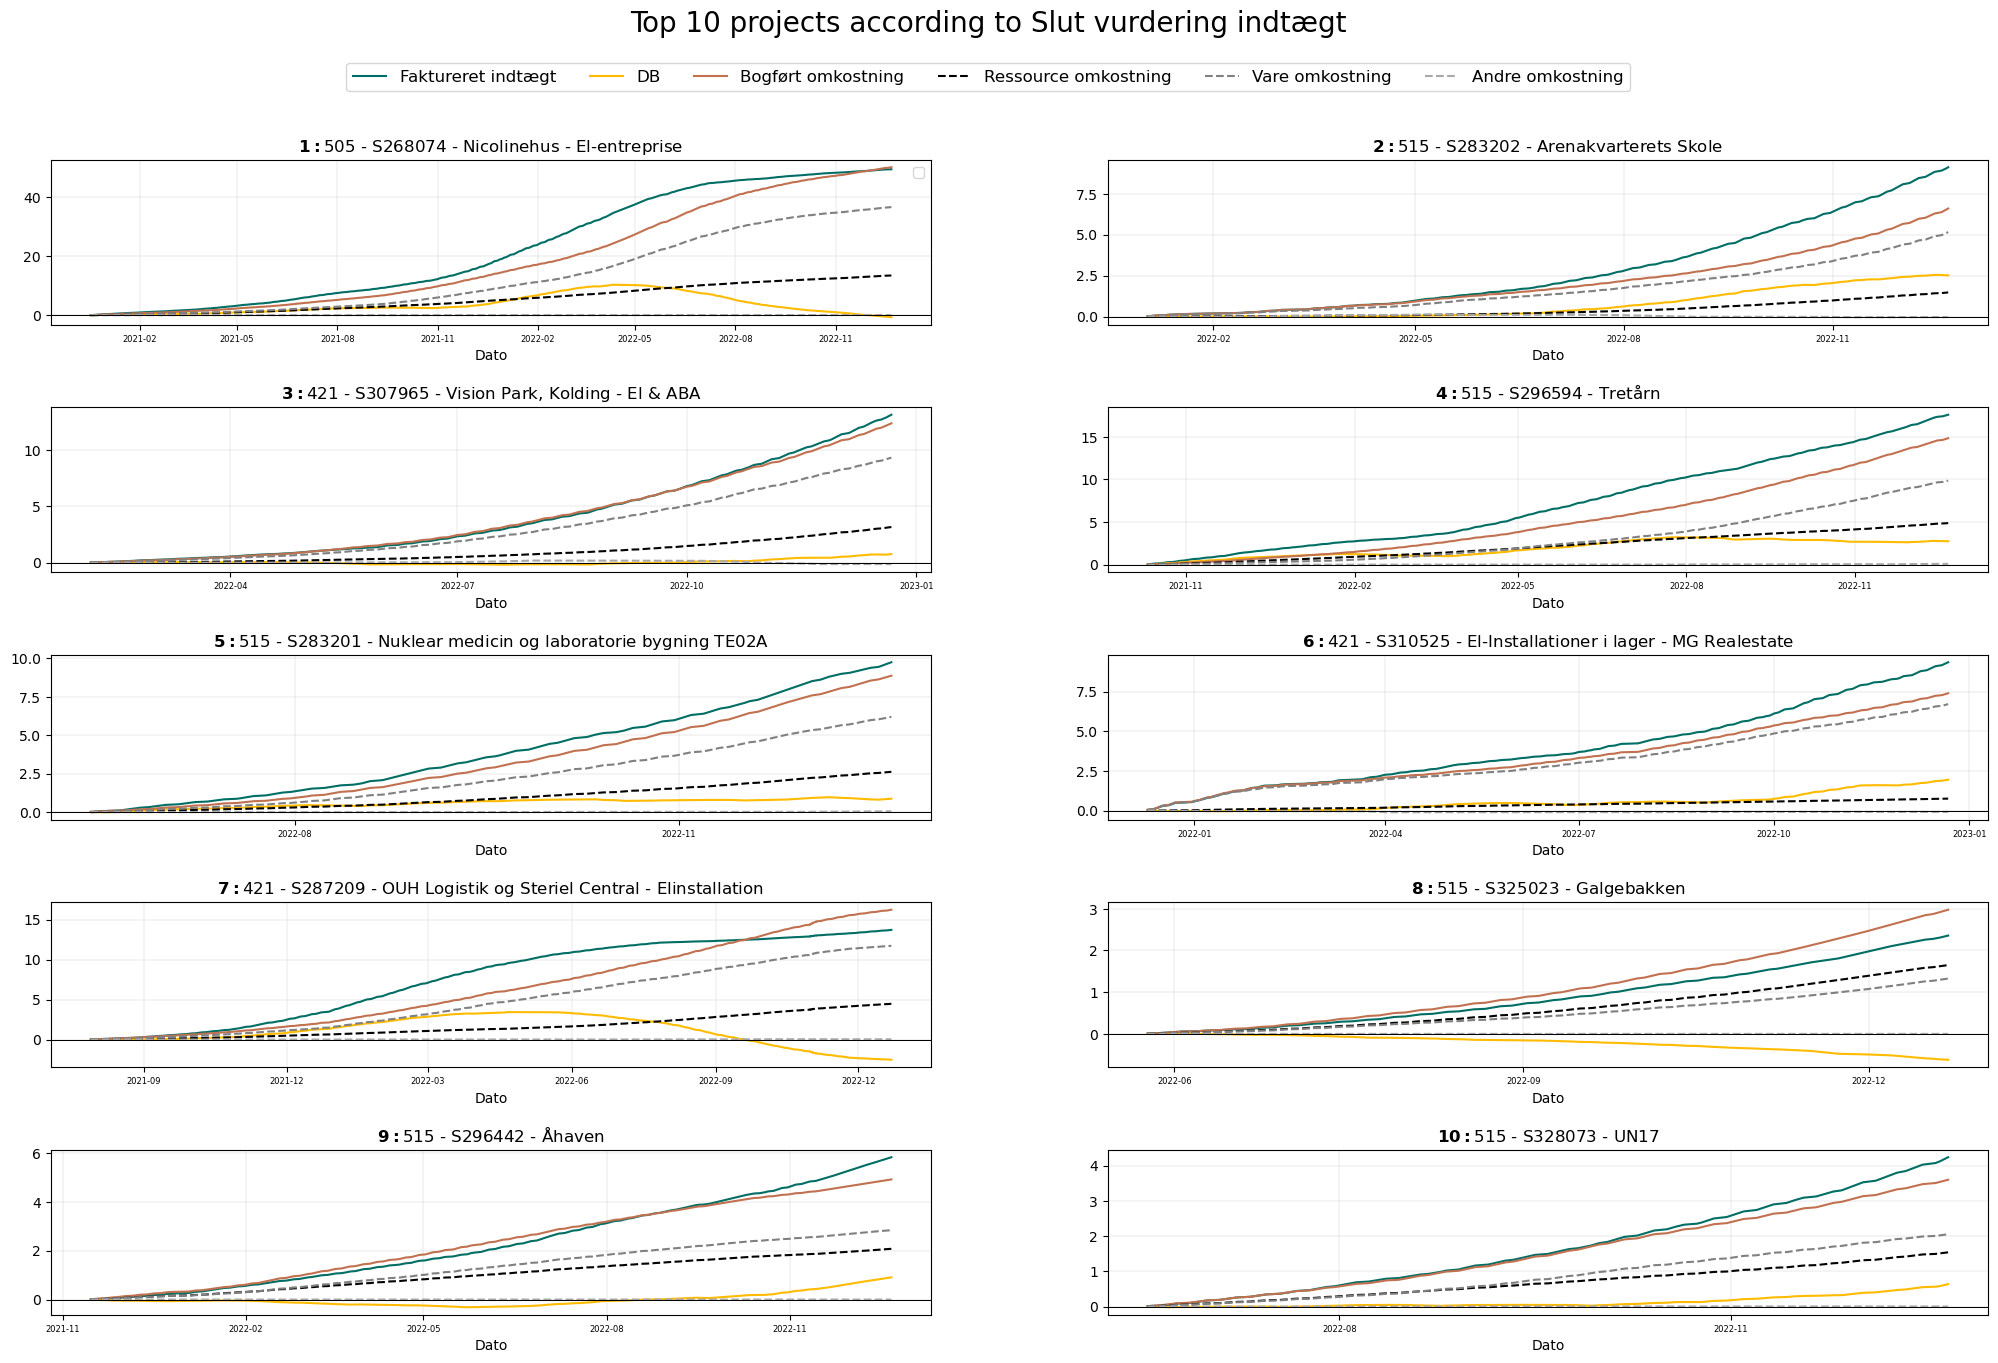

In [15]:
# Plot 10 project in one figure using SigmaMu.
fig, ax = plt.subplots(5,2)
# make a little extra space between the subplots
fig.subplots_adjust(hspace=0.5)
# size of the figure
fig.set_size_inches(25, 15)
# Title of the figure
fig.suptitle('Top 10 projects according to ' + param, fontsize=20)


# Project 1
ax[0,0].plot(dfJob1.index, dfJob1['Faktureret indtægt SigmaMu'], color='#006e64')
ax[0,0].plot(dfJob1.index, dfJob1['DB SigmaMu'], color='#ffbb00')
ax[0,0].plot(dfJob1.index, dfJob1['Bogført omkostning SigmaMu'],color='#c17150')
ax[0,0].plot(dfJob1.index, dfJob1['Ressource omkostning SigmaMu'],linestyle='--', color='black')
ax[0,0].plot(dfJob1.index, dfJob1['Vare omkostning SigmaMu'],linestyle='--', color='grey')
ax[0,0].plot(dfJob1.index, dfJob1['Andre omkostning SigmaMu'],linestyle='--', color='darkgrey')
# ax0 = ax[0,0].twinx()
# ax0.plot(dfJob1.index, dfJob1['DG'], color='#ff0000', linestyle = '-.')
# ax0.plot(dfJob1.index, dfJob1['Slut vurdering DG'], linestyle = '-.')
# Legend
ax[0,0].legend()
# Title
ax[0,0].set_title(r"$\bf{1: }$" + dfJob1Desc)
# X-axis
ax[0,0].set_xlabel('Dato')
# Change x-axis ticks to every 3 months
ax[0,0].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
# X-axis label size small
ax[0,0].tick_params(axis='x', labelsize=6)
# Add gridlines grey
ax[0,0].grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
# Add line for y=0
ax[0,0].axhline(y=0, color='black', linestyle='-', linewidth=0.75)

# Project 2
ax[0,1].plot(dfJob2.index, dfJob2['Faktureret indtægt SigmaMu'], color='#006e64')
ax[0,1].plot(dfJob2.index, dfJob2['DB SigmaMu'], color='#ffbb00')
ax[0,1].plot(dfJob2.index, dfJob2['Bogført omkostning SigmaMu'],color='#c17150')
ax[0,1].plot(dfJob2.index, dfJob2['Ressource omkostning SigmaMu'], linestyle='--', color='black')
ax[0,1].plot(dfJob2.index, dfJob2['Vare omkostning SigmaMu'],linestyle='--', color='grey')
ax[0,1].plot(dfJob2.index, dfJob2['Andre omkostning SigmaMu'],linestyle='--', color='darkgrey')
# ax0 = ax[0,1].twinx()
# ax0.plot(dfJob2.index, dfJob2['DG'], color='#ff0000', linestyle = '-.')
# ax0.plot(dfJob2.index, dfJob2['Slut vurdering DG'], linestyle = '-.')
# Title
ax[0,1].set_title(r"$\bf{2: }$" + dfJob2Desc)
# X-axis
ax[0,1].set_xlabel('Dato')
# Change x-axis ticks to every 3 months
ax[0,1].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
# X-axis label size small
ax[0,1].tick_params(axis='x', labelsize=6)
# Add gridlines grey
ax[0,1].grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
# Add line for y=0
ax[0,1].axhline(y=0, color='black', linestyle='-', linewidth=0.75)

# Project 3
ax[1,0].plot(dfJob3.index, dfJob3['Faktureret indtægt SigmaMu'], color='#006e64')
ax[1,0].plot(dfJob3.index, dfJob3['DB SigmaMu'], color='#ffbb00')
ax[1,0].plot(dfJob3.index, dfJob3['Bogført omkostning SigmaMu'],color='#c17150')
ax[1,0].plot(dfJob3.index, dfJob3['Ressource omkostning SigmaMu'],linestyle='--', color='black')
ax[1,0].plot(dfJob3.index, dfJob3['Vare omkostning SigmaMu'],linestyle='--', color='grey')
ax[1,0].plot(dfJob3.index, dfJob3['Andre omkostning SigmaMu'],linestyle='--', color='darkgrey')
# ax0 = ax[1,0].twinx()
# ax0.plot(dfJob3.index, dfJob3['DG'], color='#ff0000', linestyle = '-.')
# ax0.plot(dfJob3.index, dfJob3['Slut vurdering DG'], linestyle = '-.')
# Title
ax[1,0].set_title(r"$\bf{3: }$" + dfJob3Desc)
# X-axis
ax[1,0].set_xlabel('Dato')
# Change x-axis ticks to every 3 months
ax[1,0].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
# X-axis label size small
ax[1,0].tick_params(axis='x', labelsize=6)
# Add gridlines grey
ax[1,0].grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
# Add line for y=0
ax[1,0].axhline(y=0, color='black', linestyle='-', linewidth=0.75)

# Project 4

ax[1,1].plot(dfJob4.index, dfJob4['Faktureret indtægt SigmaMu'], color='#006e64')
ax[1,1].plot(dfJob4.index, dfJob4['DB SigmaMu'], color='#ffbb00')
ax[1,1].plot(dfJob4.index, dfJob4['Bogført omkostning SigmaMu'],color='#c17150')
ax[1,1].plot(dfJob4.index, dfJob4['Ressource omkostning SigmaMu'],linestyle='--', color='black')
ax[1,1].plot(dfJob4.index, dfJob4['Vare omkostning SigmaMu'],linestyle='--', color='grey')
ax[1,1].plot(dfJob4.index, dfJob4['Andre omkostning SigmaMu'],linestyle='--', color='darkgrey')
# ax0 = ax[1,1].twinx()
# ax0.plot(dfJob4.index, dfJob4['DG'], color='#ff0000', linestyle = '-.')
# ax0.plot(dfJob4.index, dfJob4['Slut vurdering DG'], linestyle = '-.')
# Title
ax[1,1].set_title(r"$\bf{4: }$" + dfJob4Desc)
# X-axis
ax[1,1].set_xlabel('Dato')
# Change x-axis ticks to every 3 months
ax[1,1].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
# X-axis label size small
ax[1,1].tick_params(axis='x', labelsize=6)
# Add gridlines grey
ax[1,1].grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
# Add line for y=0
ax[1,1].axhline(y=0, color='black', linestyle='-', linewidth=0.75)

# Project 5
ax[2,0].plot(dfJob5.index, dfJob5['Faktureret indtægt SigmaMu'], color='#006e64')
ax[2,0].plot(dfJob5.index, dfJob5['DB SigmaMu'], color='#ffbb00')
ax[2,0].plot(dfJob5.index, dfJob5['Bogført omkostning SigmaMu'],color='#c17150')
ax[2,0].plot(dfJob5.index, dfJob5['Ressource omkostning SigmaMu'],linestyle='--', color='black')
ax[2,0].plot(dfJob5.index, dfJob5['Vare omkostning SigmaMu'],linestyle='--', color='grey')
ax[2,0].plot(dfJob5.index, dfJob5['Andre omkostning SigmaMu'],linestyle='--', color='darkgrey')
# ax0 = ax[2,0].twinx()
# ax0.plot(dfJob4.index, dfJob4['DG'], color='#ff0000', linestyle = '-.')
# ax0.plot(dfJob4.index, dfJob4['Slut vurdering DG'], linestyle = '-.')
# Title
ax[2,0].set_title(r"$\bf{5: }$" + dfJob5Desc)
# X-axis
ax[2,0].set_xlabel('Dato')
# Change x-axis ticks to every 3 months
ax[2,0].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
# X-axis label size small
ax[2,0].tick_params(axis='x', labelsize=6)
# Add gridlines grey
ax[2,0].grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
# Add line for y=0
ax[2,0].axhline(y=0, color='black', linestyle='-', linewidth=0.75)

# Project 6
ax[2,1].plot(dfJob6.index, dfJob6['Faktureret indtægt SigmaMu'], color='#006e64')
ax[2,1].plot(dfJob6.index, dfJob6['DB SigmaMu'], color='#ffbb00')
ax[2,1].plot(dfJob6.index, dfJob6['Bogført omkostning SigmaMu'],color='#c17150')
ax[2,1].plot(dfJob6.index, dfJob6['Ressource omkostning SigmaMu'],linestyle='--', color='black')
ax[2,1].plot(dfJob6.index, dfJob6['Vare omkostning SigmaMu'],linestyle='--', color='grey')
ax[2,1].plot(dfJob6.index, dfJob6['Andre omkostning SigmaMu'],linestyle='--', color='darkgrey')
# ax0 = ax[2,1].twinx()
# ax0.plot(dfJob6.index, dfJob6['DG'], color='#ff0000', linestyle = '-.')
# ax0.plot(dfJob6.index, dfJob6['Slut vurdering DG'], linestyle = '-.')
# Title
ax[2,1].set_title(r"$\bf{6: }$" + dfJob6Desc)
# X-axis
ax[2,1].set_xlabel('Dato')
# Change x-axis ticks to every 3 months
ax[2,1].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
# X-axis label size small
ax[2,1].tick_params(axis='x', labelsize=6)
# Add gridlines grey
ax[2,1].grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
# Add line for y=0
ax[2,1].axhline(y=0, color='black', linestyle='-', linewidth=0.75)

# Project 7
ax[3,0].plot(dfJob7.index, dfJob7['Faktureret indtægt SigmaMu'], color='#006e64')
ax[3,0].plot(dfJob7.index, dfJob7['DB SigmaMu'], color='#ffbb00')
ax[3,0].plot(dfJob7.index, dfJob7['Bogført omkostning SigmaMu'],color='#c17150')
ax[3,0].plot(dfJob7.index, dfJob7['Ressource omkostning SigmaMu'],linestyle='--', color='black')
ax[3,0].plot(dfJob7.index, dfJob7['Vare omkostning SigmaMu'],linestyle='--', color='grey')
ax[3,0].plot(dfJob7.index, dfJob7['Andre omkostning SigmaMu'],linestyle='--', color='darkgrey')
# ax0 = ax[3,0].twinx()
# ax0.plot(dfJob7.index, dfJob7['DG'], color='#ff0000', linestyle = '-.')
# ax0.plot(dfJob7.index, dfJob7['Slut vurdering DG'], linestyle = '-.')
# Title
ax[3,0].set_title(r"$\bf{7: }$" + dfJob7Desc)
# X-axis
ax[3,0].set_xlabel('Dato')
# Change x-axis ticks to every 3 months
ax[3,0].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
# X-axis label size small
ax[3,0].tick_params(axis='x', labelsize=6)
# Add gridlines grey
ax[3,0].grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
# Add line for y=0
ax[3,0].axhline(y=0, color='black', linestyle='-', linewidth=0.75)

# Project 8
ax[3,1].plot(dfJob8.index, dfJob8['Faktureret indtægt SigmaMu'], color='#006e64')
ax[3,1].plot(dfJob8.index, dfJob8['DB SigmaMu'], color='#ffbb00')
ax[3,1].plot(dfJob8.index, dfJob8['Bogført omkostning SigmaMu'],color='#c17150')
ax[3,1].plot(dfJob8.index, dfJob8['Ressource omkostning SigmaMu'],linestyle='--', color='black')  
ax[3,1].plot(dfJob8.index, dfJob8['Vare omkostning SigmaMu'],linestyle='--', color='grey')
ax[3,1].plot(dfJob8.index, dfJob8['Andre omkostning SigmaMu'],linestyle='--', color='darkgrey')
# ax0 = ax[3,1].twinx()
# ax0.plot(dfJob8.index, dfJob8['DG'], color='#ff0000', linestyle = '-.')
# ax0.plot(dfJob8.index, dfJob8['Slut vurdering DG'], linestyle = '-.')
# Title
ax[3,1].set_title(r"$\bf{8: }$" + dfJob8Desc)
# X-axis
ax[3,1].set_xlabel('Dato')
# Change x-axis ticks to every 3 months
ax[3,1].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
# X-axis label size small
ax[3,1].tick_params(axis='x', labelsize=6)
# Add gridlines grey
ax[3,1].grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
# Add line for y=0
ax[3,1].axhline(y=0, color='black', linestyle='-', linewidth=0.75)

# Project 9
ax[4,0].plot(dfJob9.index, dfJob9['Faktureret indtægt SigmaMu'], color='#006e64')
ax[4,0].plot(dfJob9.index, dfJob9['DB SigmaMu'], color='#ffbb00')
ax[4,0].plot(dfJob9.index, dfJob9['Bogført omkostning SigmaMu'],color='#c17150')
ax[4,0].plot(dfJob9.index, dfJob9['Ressource omkostning SigmaMu'],linestyle='--', color='black')
ax[4,0].plot(dfJob9.index, dfJob9['Vare omkostning SigmaMu'],linestyle='--', color='grey')
ax[4,0].plot(dfJob9.index, dfJob9['Andre omkostning SigmaMu'],linestyle='--', color='darkgrey')
# ax0 = ax[4,0].twinx()
# ax0.plot(dfJob9.index, dfJob9['DG'], color='#ff0000', linestyle = '-.')
# ax0.plot(dfJob9.index, dfJob9['Slut vurdering DG'], linestyle = '-.')
# Title
ax[4,0].set_title(r"$\bf{9: }$" + dfJob9Desc)
# X-axis
ax[4,0].set_xlabel('Dato')
# Change x-axis ticks to every 3 months
ax[4,0].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
# X-axis label size small
ax[4,0].tick_params(axis='x', labelsize=6)
# Add gridlines grey
ax[4,0].grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
# Add line for y=0
ax[4,0].axhline(y=0, color='black', linestyle='-', linewidth=0.75)

# Project 10
ax[4,1].plot(dfJob10.index, dfJob10['Faktureret indtægt SigmaMu'], color='#006e64')
ax[4,1].plot(dfJob10.index, dfJob10['DB SigmaMu'], color='#ffbb00')
ax[4,1].plot(dfJob10.index, dfJob10['Bogført omkostning SigmaMu'],color='#c17150')
ax[4,1].plot(dfJob10.index, dfJob10['Ressource omkostning SigmaMu'],linestyle='--', color='black')
ax[4,1].plot(dfJob10.index, dfJob10['Vare omkostning SigmaMu'],linestyle='--', color='grey')
ax[4,1].plot(dfJob10.index, dfJob10['Andre omkostning SigmaMu'],linestyle='--', color='darkgrey')
# ax0 = ax[4,1].twinx()
# ax0.plot(dfJob10.index, dfJob10['DG'], color='#ff0000', linestyle = '-.')
# ax0.plot(dfJob10.index, dfJob10['Slut vurdering DG'], linestyle = '-.')
# Title
ax[4,1].set_title(r"$\bf{10: }$" + dfJob10Desc)
# X-axis
ax[4,1].set_xlabel('Dato')
# Change x-axis ticks to every 3 months
ax[4,1].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
# X-axis label size small
ax[4,1].tick_params(axis='x', labelsize=6)
# Add gridlines grey
ax[4,1].grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
# Add line for y=0
ax[4,1].axhline(y=0, color='black', linestyle='-', linewidth=0.75)


# Legend below title
# Add label to legend
fig.legend(['Faktureret indtægt', 'DB', 'Bogført omkostning', 'Ressource omkostning', 'Vare omkostning', 'Andre omkostning'],loc='upper center', bbox_to_anchor=(0.5, 0.95), ncol=6, fontsize=12)
# Save plot as pdf
plt.savefig("./Top10SigmaMu.pdf", format="pdf", bbox_inches="tight")
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


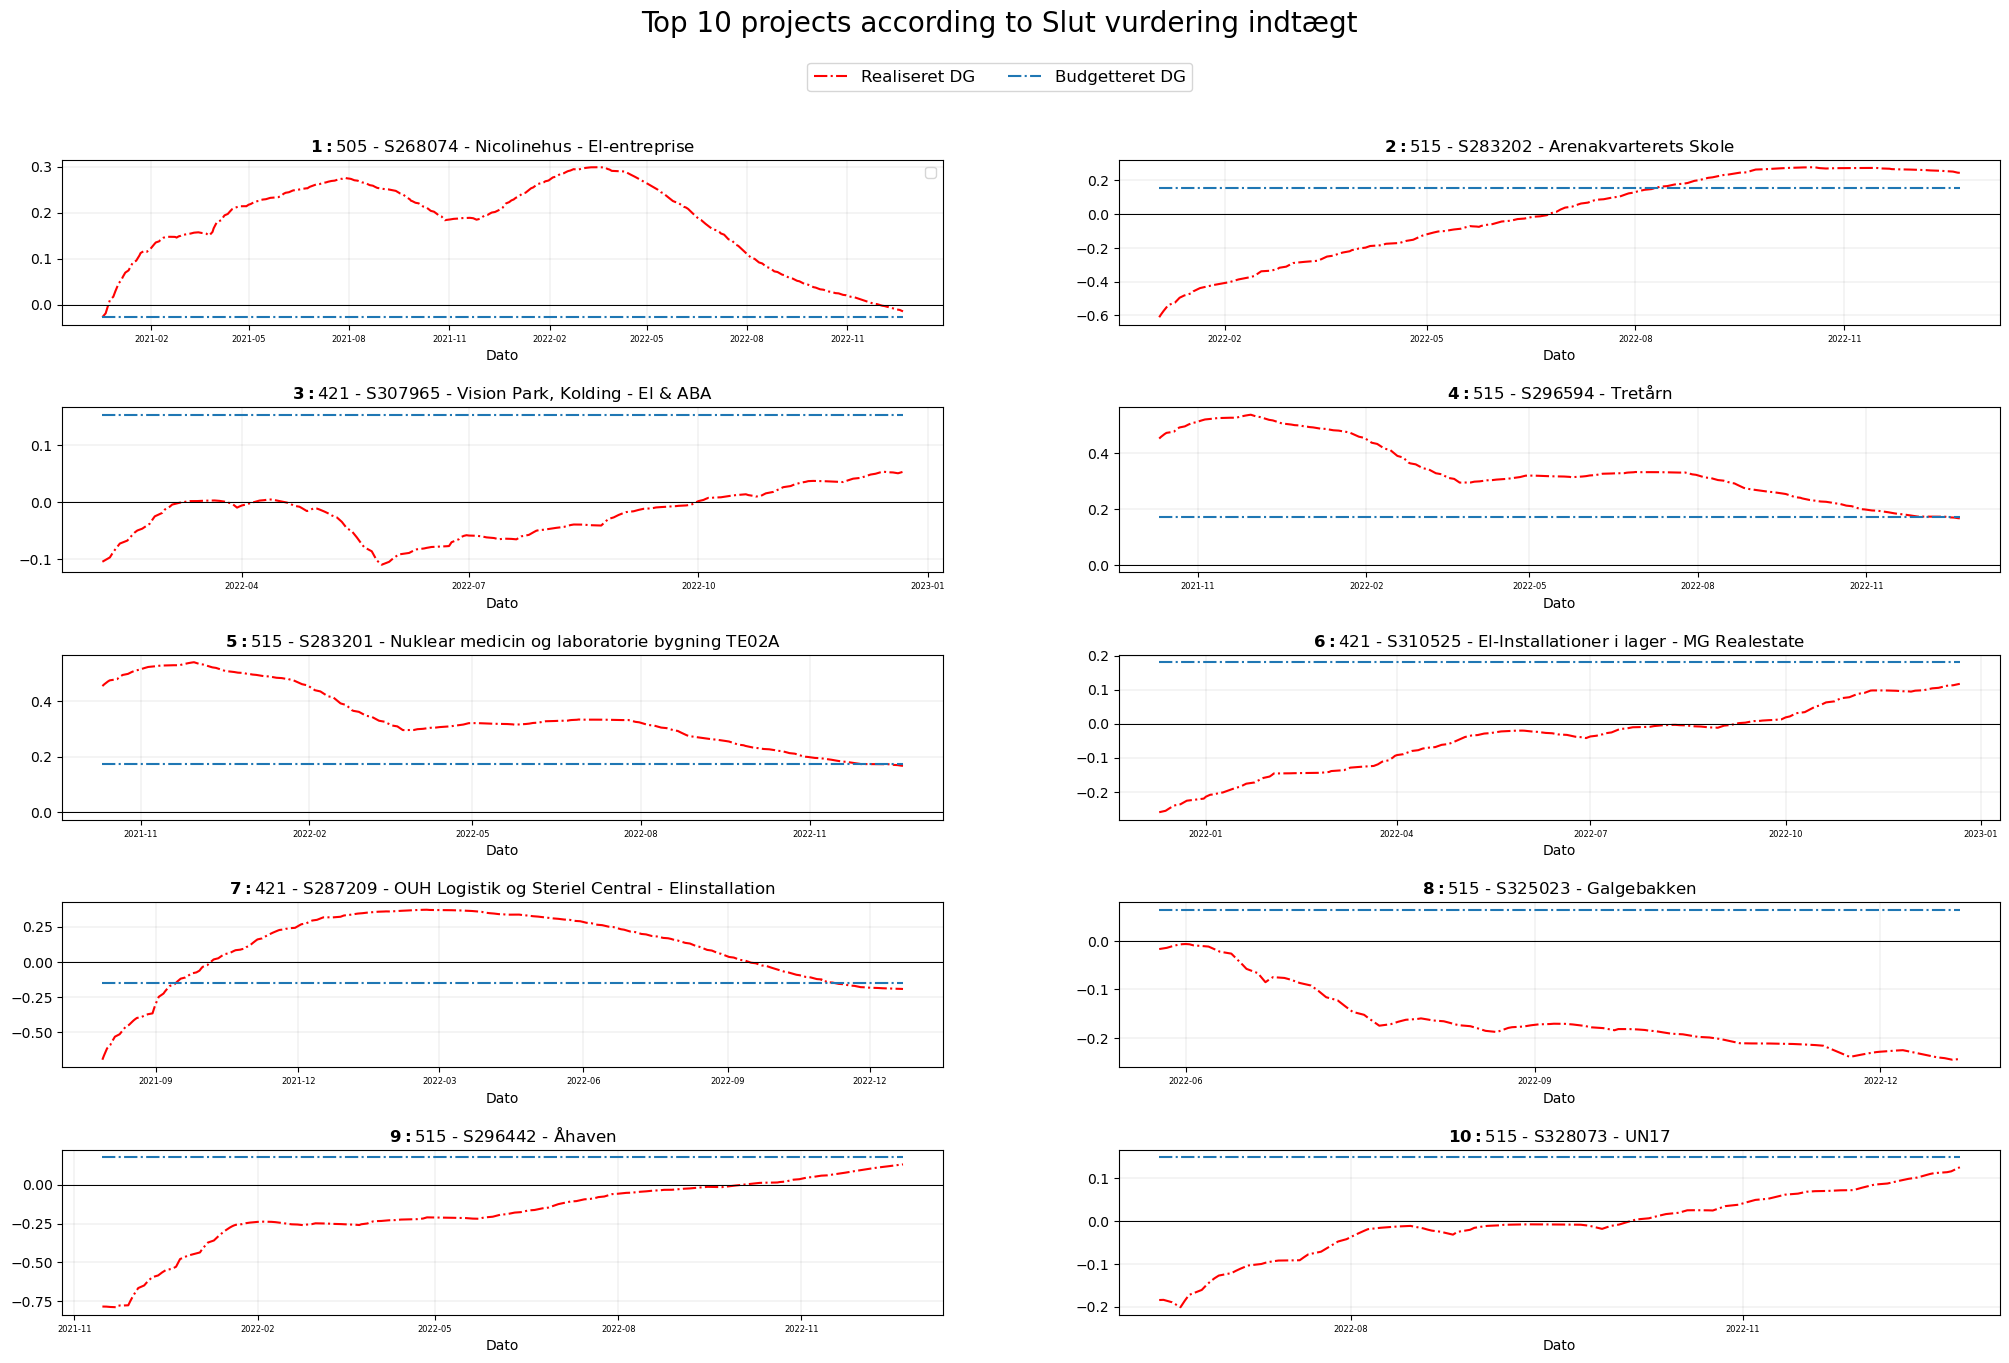

In [16]:
# Plot 10 project in one figure using DG.
fig, ax = plt.subplots(5,2)
# make a little extra space between the subplots
fig.subplots_adjust(hspace=0.5)
# size of the figure
fig.set_size_inches(25, 15)
# Title of the figure
fig.suptitle('Top 10 projects according to ' + param, fontsize=20)


# Project 1
ax[0,0].plot(dfJob1.index, dfJob1['DG'], color='#ff0000', linestyle = '-.')
ax[0,0].plot(dfJob1.index, dfJob1['Slut vurdering DG'], linestyle = '-.')
# Legend
ax[0,0].legend()
# Title
ax[0,0].set_title(r"$\bf{1: }$" + dfJob1Desc)
# X-axis
ax[0,0].set_xlabel('Dato')
# Change x-axis ticks to every 3 months
ax[0,0].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
# X-axis label size small
ax[0,0].tick_params(axis='x', labelsize=6)
# Add gridlines grey
ax[0,0].grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
# Add line for y=0
ax[0,0].axhline(y=0, color='black', linestyle='-', linewidth=0.75)

# Project 2
ax[0,1].plot(dfJob2.index, dfJob2['DG'], color='#ff0000', linestyle = '-.')
ax[0,1].plot(dfJob2.index, dfJob2['Slut vurdering DG'], linestyle = '-.')
# Title
ax[0,1].set_title(r"$\bf{2: }$" + dfJob2Desc)
# X-axis
ax[0,1].set_xlabel('Dato')
# Change x-axis ticks to every 3 months
ax[0,1].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
# X-axis label size small
ax[0,1].tick_params(axis='x', labelsize=6)
# Add gridlines grey
ax[0,1].grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
# Add line for y=0
ax[0,1].axhline(y=0, color='black', linestyle='-', linewidth=0.75)

# Project 3
ax[1,0].plot(dfJob3.index, dfJob3['DG'], color='#ff0000', linestyle = '-.')
ax[1,0].plot(dfJob3.index, dfJob3['Slut vurdering DG'], linestyle = '-.')
# Title
ax[1,0].set_title(r"$\bf{3: }$" + dfJob3Desc)
# X-axis
ax[1,0].set_xlabel('Dato')
# Change x-axis ticks to every 3 months
ax[1,0].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
# X-axis label size small
ax[1,0].tick_params(axis='x', labelsize=6)
# Add gridlines grey
ax[1,0].grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
# Add line for y=0
ax[1,0].axhline(y=0, color='black', linestyle='-', linewidth=0.75)

# Project 4
ax[1,1].plot(dfJob4.index, dfJob4['DG'], color='#ff0000', linestyle = '-.')
ax[1,1].plot(dfJob4.index, dfJob4['Slut vurdering DG'], linestyle = '-.')
# Title
ax[1,1].set_title(r"$\bf{4: }$" + dfJob4Desc)
# X-axis
ax[1,1].set_xlabel('Dato')
# Change x-axis ticks to every 3 months
ax[1,1].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
# X-axis label size small
ax[1,1].tick_params(axis='x', labelsize=6)
# Add gridlines grey
ax[1,1].grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
# Add line for y=0
ax[1,1].axhline(y=0, color='black', linestyle='-', linewidth=0.75)

# Project 5
ax[2,0].plot(dfJob4.index, dfJob4['DG'], color='#ff0000', linestyle = '-.')
ax[2,0].plot(dfJob4.index, dfJob4['Slut vurdering DG'], linestyle = '-.')
# Title
ax[2,0].set_title(r"$\bf{5: }$" + dfJob5Desc)
# X-axis
ax[2,0].set_xlabel('Dato')
# Change x-axis ticks to every 3 months
ax[2,0].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
# X-axis label size small
ax[2,0].tick_params(axis='x', labelsize=6)
# Add gridlines grey
ax[2,0].grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
# Add line for y=0
ax[2,0].axhline(y=0, color='black', linestyle='-', linewidth=0.75)

# Project 6
ax[2,1].plot(dfJob6.index, dfJob6['DG'], color='#ff0000', linestyle = '-.')
ax[2,1].plot(dfJob6.index, dfJob6['Slut vurdering DG'], linestyle = '-.')
# Title
ax[2,1].set_title(r"$\bf{6: }$" + dfJob6Desc)
# X-axis
ax[2,1].set_xlabel('Dato')
# Change x-axis ticks to every 3 months
ax[2,1].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
# X-axis label size small
ax[2,1].tick_params(axis='x', labelsize=6)
# Add gridlines grey
ax[2,1].grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
# Add line for y=0
ax[2,1].axhline(y=0, color='black', linestyle='-', linewidth=0.75)

# Project 7
ax[3,0].plot(dfJob7.index, dfJob7['DG'], color='#ff0000', linestyle = '-.')
ax[3,0].plot(dfJob7.index, dfJob7['Slut vurdering DG'], linestyle = '-.')
# Title
ax[3,0].set_title(r"$\bf{7: }$" + dfJob7Desc)
# X-axis
ax[3,0].set_xlabel('Dato')
# Change x-axis ticks to every 3 months
ax[3,0].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
# X-axis label size small
ax[3,0].tick_params(axis='x', labelsize=6)
# Add gridlines grey
ax[3,0].grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
# Add line for y=0
ax[3,0].axhline(y=0, color='black', linestyle='-', linewidth=0.75)

# Project 8
ax[3,1].plot(dfJob8.index, dfJob8['DG'], color='#ff0000', linestyle = '-.')
ax[3,1].plot(dfJob8.index, dfJob8['Slut vurdering DG'], linestyle = '-.')
# Title
ax[3,1].set_title(r"$\bf{8: }$" + dfJob8Desc)
# X-axis
ax[3,1].set_xlabel('Dato')
# Change x-axis ticks to every 3 months
ax[3,1].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
# X-axis label size small
ax[3,1].tick_params(axis='x', labelsize=6)
# Add gridlines grey
ax[3,1].grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
# Add line for y=0
ax[3,1].axhline(y=0, color='black', linestyle='-', linewidth=0.75)

# Project 9
ax[4,0].plot(dfJob9.index, dfJob9['DG'], color='#ff0000', linestyle = '-.')
ax[4,0].plot(dfJob9.index, dfJob9['Slut vurdering DG'], linestyle = '-.')
# Title
ax[4,0].set_title(r"$\bf{9: }$" + dfJob9Desc)
# X-axis
ax[4,0].set_xlabel('Dato')
# Change x-axis ticks to every 3 months
ax[4,0].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
# X-axis label size small
ax[4,0].tick_params(axis='x', labelsize=6)
# Add gridlines grey
ax[4,0].grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
# Add line for y=0
ax[4,0].axhline(y=0, color='black', linestyle='-', linewidth=0.75)

# Project 10
ax[4,1].plot(dfJob10.index, dfJob10['DG'], color='#ff0000', linestyle = '-.')
ax[4,1].plot(dfJob10.index, dfJob10['Slut vurdering DG'], linestyle = '-.')
# Title
ax[4,1].set_title(r"$\bf{10: }$" + dfJob10Desc)
# X-axis
ax[4,1].set_xlabel('Dato')
# Change x-axis ticks to every 3 months
ax[4,1].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
# X-axis label size small
ax[4,1].tick_params(axis='x', labelsize=6)
# Add gridlines grey
ax[4,1].grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
# Add line for y=0
ax[4,1].axhline(y=0, color='black', linestyle='-', linewidth=0.75)


# Legend below title
# Add label to legend
fig.legend(['Realiseret DG', 'Budgetteret DG'],loc='upper center', bbox_to_anchor=(0.5, 0.95), ncol=6, fontsize=12)
# Save plot as pdf
plt.savefig("./Top10DG.pdf", format="pdf", bbox_inches="tight")
plt.show()

### Principle Component Analysis (PCA) ###

In [25]:
dfPCA = dfJob1['DB mu']

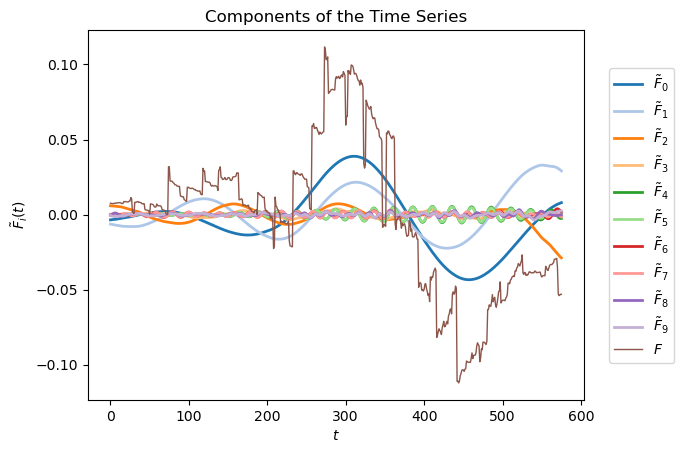

In [49]:
# Choosing hyper-parameters and Create Trajectory Matrix
N = len(dfPCA)

L = 200 # The window length
K = N - L + 1  # number of columns in the trajectory matrix
t = np.arange(0,N)
X = np.column_stack([dfPCA[i:i+L] for i in range(0,K)])
d = 10

# PCA Decomposition
def PCA_decomposition(A):
  M = np.mean(A, axis=0)
  C = A - M
  V = np.cov(C)
  values, vectors = np.linalg.eig(V)
    
  return values, vectors


# Zero mean for each column of data
from sklearn.preprocessing import StandardScaler
sX = StandardScaler(copy=True)
X_trans = sX.fit_transform(X)

# Decompose Time Series using PCA
values, vectors = PCA_decomposition(X)
values.shape, vectors.shape
U_k = vectors
U_k.shape

# Reconstruct X_i using the first d principal components
X_elem_pca = np.array([np.dot(np.dot(np.expand_dims(U_k[:,i], axis=1), np.expand_dims(U_k[:,i].T, axis=0)), X) for i in range(0,d)])

# Convert Trajectory matrix (Hankel Matrix) to Time Series Data
def X_to_TS(X_i):
    # Reverse the column ordering of X_i
    X_rev = X_i[::-1]
    return np.array([X_rev.diagonal(i).mean() for i in range(-X_i.shape[0]+1, X_i.shape[1])])


n = min(70,d) # In case of noiseless time series with d < 12.

# Fiddle with colour cycle - need more colours!
fig = plt.subplot()
color_cycle = plt.cycler(color=plt.get_cmap('tab20').colors)
fig.axes.set_prop_cycle(color_cycle)

# Convert elementary matrices straight to a time series - no need to construct any Hankel matrices.
for i in range(n):
    F_i = X_to_TS(X_elem_pca[i])
    fig.axes.plot(t, F_i, lw=2)

fig.axes.plot(t, dfPCA, alpha=1, lw=1)
fig.set_xlabel("$t$")
fig.set_ylabel(r"$\tilde{F}_i(t)$")
legend = [r"$\tilde{F}_{%s}$" %i for i in range(n)] + ["$F$"]
fig.set_title("Components of the Time Series", fontsize=12)
plt.savefig("./PCA_First12.pdf", format="pdf", bbox_inches="tight")
fig.legend(legend, loc=(1.05,0.1))


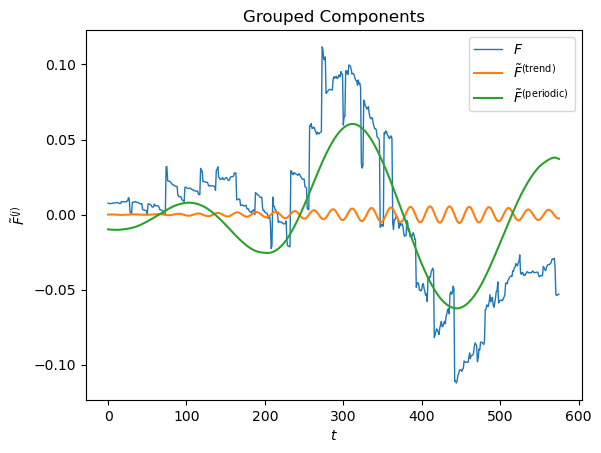

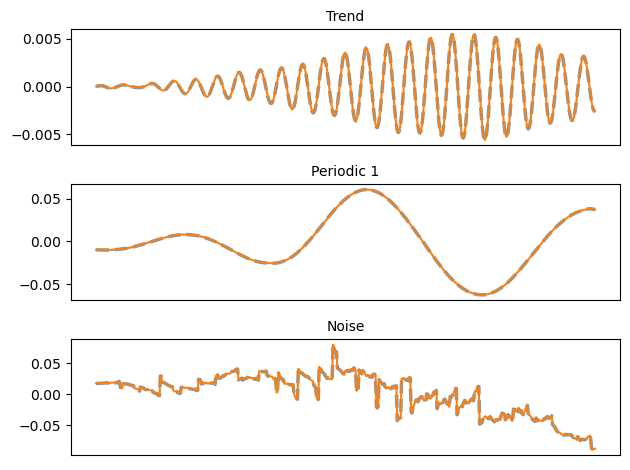

In [48]:
# Assemble the grouped components of the time series.
F_trend = X_to_TS(X_elem_pca[[4]].sum(axis=0))
F_periodic1 = X_to_TS(X_elem_pca[[0,1]].sum(axis=0))
F_periodic2 = X_to_TS(X_elem_pca[[4,5]].sum(axis=0))
F_noise = X_to_TS(X_elem_pca[7:].sum(axis=0))
F_noise = dfPCA - F_trend - F_periodic1
# Plot the toy time series and its separated components on a single plot.
plt.plot(t,dfPCA, lw=1)
plt.plot(t, F_trend)
plt.plot(t, F_periodic1)
# plt.plot(t, F_periodic2)

# plt.plot(t, F_noise, alpha=0.5)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}^{(j)}$")
groups = ["trend"
          , "periodic"
          , "noise"
          ]
legend = ["$F$"] + [r"$\tilde{F}^{(\mathrm{%s})}$"%group for group in groups]
plt.legend(legend)
plt.title("Grouped Components", fontsize = 12)
plt.savefig("./PCA_Grouped.pdf", format="pdf", bbox_inches="tight")
plt.show()

# A list of tuples so we can create the next plot with a loop.
components = [("Trend", F_trend, F_trend), 
              ("Periodic 1", F_periodic1, F_periodic1),
              ("Noise", F_noise, F_noise)
              ]

# Plot the separated components and original components together.
fig = plt.figure()
n=1
for name, orig_comp, ssa_comp in components:
    ax = fig.add_subplot(3,1,n)
    ax.plot(t, orig_comp, linestyle="--", lw=2.5, alpha=0.7)
    ax.plot(t, ssa_comp)
    ax.set_title(name, fontsize=10)
    ax.set_xticks([])
    n += 1
fig.tight_layout()
plt.savefig("./PCA_Components.pdf", format="pdf", bbox_inches="tight")
fig.tight_layout()



#### Using sklearn ####

In [50]:
%matplotlib inline
import pandas as pd # for using pandas daraframe
import numpy as np # for som math operations
from sklearn.preprocessing import StandardScaler # for standardizing the Data
from sklearn.decomposition import PCA # for PCA calculation
import matplotlib.pyplot as plt # for plotting

In [51]:
dfPCA = dfJob1

In [52]:
# Drop first 7 columns
dfPCA = dfPCA.drop(dfJob5.columns[[0,1,2,3,4,5,6,7]], axis=1)
dfPCA = dfPCA.fillna(0)
dfPCA.head()

,Slut vurdering indtægt,Slut vurdering omkostning,Slut vurdering DB,Faktureret indtægt,Bogført omkostning,Ressource omkostning,Vare omkostning,Andre omkostning,DG,DB,...,Slut vurdering indtægt SigmaMu,Slut vurdering omkostning SigmaMu,Slut vurdering DB SigmaMu,Faktureret indtægt SigmaMu,Bogført omkostning SigmaMu,Ressource omkostning SigmaMu,Vare omkostning SigmaMu,Andre omkostning SigmaMu,DB SigmaMu,Slut vurdering DG
Dato,,,,,,,,,,,,,,,,,,,,,
2021-03-09,52.375572,53.797271,-1.421699,0.0,0.096751,0.020687,0.076064,0.0,0.121992,-0.096751,...,52.375572,53.797271,-1.421699,0.024917,0.022446,0.009499,0.012947,0.0,0.002471,-0.027144
2021-03-10,52.375572,53.797271,-1.421699,0.0,0.020611,0.020611,0.000000,0.0,0.121599,-0.020611,...,104.751144,107.594541,-2.843398,0.049834,0.045010,0.019117,0.025893,0.0,0.004824,-0.027144
2021-03-11,52.375572,53.797271,-1.421699,0.0,0.015244,0.015244,0.000000,0.0,0.121180,-0.015244,...,157.126716,161.391812,-4.265096,0.074751,0.067640,0.028805,0.038835,0.0,0.007111,-0.027144
2021-03-12,52.375572,53.797271,-1.421699,0.0,0.005003,0.009527,-0.004524,0.0,0.120788,-0.005003,...,209.502287,215.189083,-5.686795,0.099668,0.090244,0.038505,0.051739,0.0,0.009424,-0.027144
2021-03-15,52.375572,53.797271,-1.421699,0.0,0.021290,0.020534,0.000756,0.0,0.120372,-0.021290,...,261.877859,268.986353,-7.108494,0.124585,0.112910,0.048290,0.064621,0.0,0.011675,-0.027144


In [53]:
X = dfPCA.values # getting all values as a matrix of dataframe 
sc = StandardScaler() # creating a StandardScaler object
X_std = sc.fit_transform(X) # standardizing the data

In [54]:
pca = PCA(n_components = 0.60)
X_pca = pca.fit_transform(X_std) # this will fit and reduce dimensions

In [55]:
n_pcs= pca.n_components_ # get number of component
# get the index of the most important feature on EACH component
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]
initial_feature_names = dfPCA.columns
# get the most important feature names
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]
most_important_names

['Ressource omkostning Sigma',
 'Faktureret indtægt mu',
 'DB',
 'Bogført omkostning',
 'Faktureret indtægt',
 'Andre omkostning',
 'Ressource omkostning']

In [56]:
dfJob1[most_important_names]

,Ressource omkostning Sigma,Faktureret indtægt mu,DB,Bogført omkostning,Faktureret indtægt,Andre omkostning,Ressource omkostning
Dato,,,,,,,
2021-03-09,1.424908,0.024917,-0.096751,0.096751,0.0,0.0,0.020687
2021-03-10,1.445519,0.024917,-0.020611,0.020611,0.0,0.0,0.020611
2021-03-11,1.460762,0.024917,-0.015244,0.015244,0.0,0.0,0.015244
2021-03-12,1.470290,0.024917,-0.005003,0.005003,0.0,0.0,0.009527
2021-03-15,1.490824,0.024917,-0.021290,0.021290,0.0,0.0,0.020534
...,...,...,...,...,...,...,...
2022-12-16,14.681260,0.026968,-0.019561,0.019561,0.0,0.0,0.013900
2022-12-19,14.689453,0.026968,-0.129012,0.129012,0.0,0.0,0.008194
2022-12-20,14.697160,0.026968,-0.042312,0.042312,0.0,0.0,0.007707


### PyCaret Machine Learning Library ###

In [57]:
from pycaret.regression import *
dfML = dfJob1[most_important_names]
dfML

,Ressource omkostning Sigma,Faktureret indtægt mu,DB,Bogført omkostning,Faktureret indtægt,Andre omkostning,Ressource omkostning
Dato,,,,,,,
2021-03-09,1.424908,0.024917,-0.096751,0.096751,0.0,0.0,0.020687
2021-03-10,1.445519,0.024917,-0.020611,0.020611,0.0,0.0,0.020611
2021-03-11,1.460762,0.024917,-0.015244,0.015244,0.0,0.0,0.015244
2021-03-12,1.470290,0.024917,-0.005003,0.005003,0.0,0.0,0.009527
2021-03-15,1.490824,0.024917,-0.021290,0.021290,0.0,0.0,0.020534
...,...,...,...,...,...,...,...
2022-12-16,14.681260,0.026968,-0.019561,0.019561,0.0,0.0,0.013900
2022-12-19,14.689453,0.026968,-0.129012,0.129012,0.0,0.0,0.008194
2022-12-20,14.697160,0.026968,-0.042312,0.042312,0.0,0.0,0.007707


In [58]:
# Setup the model #
s = setup(dfML, target = 'DB', fold_shuffle=True)


IntProgress(value=0, description='Processing: ', max=3)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,07:50:50
Status,. . . . . . . . . . . . . . . . . .,Preprocessing Data


Text(value="Following data types have been inferred automatically, if they are correct press enter to continue…

,Data Type
Ressource omkostning Sigma,Numeric
Faktureret indtægt mu,Numeric
Bogført omkostning,Numeric
Faktureret indtægt,Numeric
Andre omkostning,Numeric
Ressource omkostning,Numeric
DB,Label


In [ ]:
# Forecasting using AutoML
